# DTN Analysis

## Loading packages

In [1]:
# Standard library imports
import math
import os
import sys
import time
from itertools import combinations
from multiprocessing import Pool

# Third-party library imports
import matplotlib.pyplot as plt
import nwbmatic as ntm
import numpy as np
import pandas as pd
import pynacollada as pyna
import pynapple as nap
import pywt
import requests
import scipy.io as sc
import seaborn as sns
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize, LogNorm, NoNorm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pycircstat.descriptive import mean as circmean
from scipy import signal, ndimage
from scipy.interpolate import interp1d
from tqdm import tqdm
import _pickle as cPickle  
from scipy.signal import filtfilt
from scipy.signal import hilbert

# Local application/library specific imports
import UFOphysio.python as phy
from UFOphysio.python.functions import *
from UFOphysio.python.ufo_detection import *

# Configuration settings
plt.rcParams.update({"axes.spines.right": False, "axes.spines.top": False})
sns.set_theme(style="ticks", palette="colorblind", font_scale=1.5)

c:\Users\Rafael\.conda\envs\pynapple\lib\site-packages\nose\plugins\manager.py:418: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
c:\Users\Rafael\.conda\envs\pynapple\lib\site-packages\pkg_resources\__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
c:\Users\Rafael\.conda\envs\pynapple\lib\site-packages\nose\importer.py:12: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import find_module, load_module, acquire_lock, release_lock


## Functions

In [2]:
def stft_gaussian_spectrogram(x, fs, window_dur=0.005, step_dur=None, detrend=False, normalize=True):
# modified from: https://github.com/drammock/spectrogram-tutorial/blob/master/spectrogram.ipynb
    
    ###########################################################################
    # detrend and normalize
    if detrend:
        x = signal.detrend(x,type='linear')
    if normalize:
        stddev = x.std()
        x = x / stddev

    ###########################################################################
    # set default for step_dur, if unspecified. This value is optimal for Gaussian windows.
    if step_dur is None:
        step_dur = window_dur / np.sqrt(np.pi) / 8.
    
    ###########################################################################
    # convert window & step durations from seconds to numbers of samples (which is what
    # scipy.signal.spectrogram takes as input).
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    
    ###########################################################################
    # make the window. A Gaussian filter needs a minimum of 6σ - 1 samples, so working
    # backward from window_nsamp we can calculate σ.
    window_sigma = (window_nsamp + 1) / 6
    window = signal.gaussian(window_nsamp, window_sigma)
    
    ###########################################################################
    # convert step size into number of overlapping samples in adjacent analysis frames
    noverlap = window_nsamp - step_nsamp
    
    ###########################################################################
    # compute the power spectral density
    freqs, times, power = signal.spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='spectrum', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)

    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=2)

    return power, times, freqs

In [3]:
def spectrogram_plot(z, times, frequencies, coif, cmap=None, norm=Normalize(), ax=None, colorbar=True):
    ###########################################################################
    # plot
    
    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    xx,yy = np.meshgrid(times,frequencies)
    ZZ = z
    
    im = ax.pcolor(xx,yy,ZZ, norm=norm, cmap=cmap)
    ax.plot(times,coif)
    ax.fill_between(times,coif, step="mid", alpha=0.4)
    
    if colorbar:
        cbaxes = inset_axes(ax, width="2%", height="90%", loc=4) 
        fig.colorbar(im,cax=cbaxes, orientation='vertical')

    ax.set_xlim(times.min(), times.max())
    ax.set_ylim(frequencies.min(), frequencies.max())

    return ax

## Data loading


In [4]:
############################################################################################### 
# GENERAL infos
###############################################################################################
data_directory = r'D:\PeyracheLab Internship\Data'
datasets = {'LMN':r'\A3024-220915A',
            'MMN':r'\A3024-220915A',
            'PostSUB':r'\A3024-220915A',
            'DTN1':r'\A4002-200120b', 
            'DTN2':r'\A4002-200121',
            'DTN3':r'\A4004-200317b',
            'DTN4':r'\A4007-200801',
            'AD':r'\B3205-231031'}

ufo_channels_nb = {'LMN':[1,0],
            'MMN':[1,0],
            'PostSUB':[1,0],
            'DTN1':[3,1], 
            'DTN2':[1,3],
            'DTN3':[0,4],
            'DTN4':[1,3],
            'DTN5':[0,2]} # channel number for signal with UFO and without (control) 

fs=20000


## Testing

### General information

In [ ]:
infos = getAllInfosV2(data_directory, datasets[session])
path = data_directory + datasets[session]
data = ntm.load_session(path, 'neurosuite')
spikes = data.spikes
position = data.position
wake_ep = data.epochs['wake']
sleep_ep = data.epochs['sleep']
ufo_ep, ufo_tsd = loadUFOs(path)

### UFO Detection

In [ ]:
############################################################################################### 
# COMPUTING TUNING CURVES
###############################################################################################
tuning_curves = nap.compute_1d_tuning_curves(spikes, position['ry'], 120, minmax=(0, 2*np.pi), ep = position.time_support.loc[[0]])
# tuning_curves = smoothAngularTuningCurves(tuning_curves, 20, 4)

###############################################################################################
# MEMORY MAP
###############################################################################################
data.load_neurosuite_xml(data.path)
channels = data.group_to_channel

sign_channels = channels[ufo_channels_nb[0]]
ctrl_channels = channels[ufo_channels_nb[1]]

filename = data.basename + ".dat"

fp, timestep = get_memory_map(data.path + r'\\' + filename, data.nChannels)

ufo_ep, ufo_tsd = detect_ufos_v2(fp, sign_channels, ctrl_channels, timestep)

In [ ]:
# Saving with pynapple
ufo_ep.save(os.path.join(path, data.basename + '_ufo_ep'))
ufo_tsd.save(os.path.join(path, data.basename + '_ufo_tsd'))

### Cross correlation

In [ ]:
spikes=data.spikes
idx = spikes._metadata[spikes._metadata["location"].str.contains(location)].index.values
spikes = spikes[idx]
spikes = spikes.getby_threshold('rate', 1, op = '>')

############################################################################################### 
# COMPUTING TUNING CURVES
###############################################################################################
tuning_curves = nap.compute_1d_tuning_curves(spikes, position['ry'], 120, minmax=(0, 2*np.pi), ep = position.time_support.loc[[0]])
tuning_curves = smoothAngularTuningCurves(tuning_curves, 20, 4)

info = nap.compute_1d_mutual_info(tuning_curves, position['ry'], position['ry'].time_support.loc[[0]], minmax=(0, 2*np.pi))['SI']

In [ ]:
#################################################################################################
# CC 
#################################################################################################

si = []
cc = []

ufo_cc = nap.compute_eventcorrelogram(spikes, ufo_tsd, 0.05, 2, sleep_ep)

names = [data.basename +'_'+str(i) for i in ufo_cc.columns]

info.index = names
ufo_cc.columns = names

si.append(info)
cc.append(ufo_cc)

cc = pd.concat(cc, axis=1)
cc = cc.rolling(window=40,win_type='gaussian',center=True,min_periods=1).mean(std=2)
si = pd.concat(si, axis=0)

order = si.sort_values().index


figure()
subplot(121)
plot(cc, alpha =0.4, color = 'grey')
plot(cc.mean(1), linewidth=3)
subplot(122)
imshow(cc[order].values.T)


figure()
count = 1
neurons = order
for i,n in enumerate(neurons):
    subplot(int(np.sqrt(len(neurons)))+1,int(np.sqrt(len(neurons)))+1,count, projection = 'polar')
    plot(tuning_curves[int(n.split('_')[1])], label = si.loc[n])
    count+=1
    gca().set_xticklabels([])

show()

## Head-Direction cells computing

In [68]:
session='AD'
location=''.join([char for char in session if char.isalpha()])

path = data_directory + datasets[session]
data = ntm.load_session(path, 'neurosuite')
spikes = data.spikes
data.load_neurosuite_xml(data.path)
channels = data.group_to_channel

data.basename

'B3205-231031'

In [69]:
#wake_ep = data.epochs['wake']
sws_ep = data.read_neuroscope_intervals('sws')
rem_ep = data.read_neuroscope_intervals('rem')

In [64]:
data.group_to_channel

{0: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])}

In [70]:
sessionInfo = sc.loadmat(path + datasets[session] + r'.sessionInfo.mat')

shanks=sessionInfo['sessionInfo']['SpkGrps'][0,0]['Channels'][0]


channels={}
for i in range(len(shanks)):
    channels[i]=list(shanks[i][0])

channels

{0: [80, 81, 82, 83],
 1: [49, 54, 48, 55, 51, 52, 50, 53],
 2: [57, 62, 56, 63, 59, 60, 58, 61],
 3: [32, 41, 33, 40, 34, 36, 37],
 4: [42, 35, 44, 39, 45, 43, 46, 47],
 5: [29, 20, 25, 18, 21, 19, 17, 16],
 6: [23, 30, 22, 31, 24, 28, 27, 26],
 7: [0, 7, 1, 6, 2, 5, 3, 4],
 8: [8, 15, 9, 14, 10, 13, 11, 12]}

In [71]:
tmp=np.sort(np.vstack((rem_ep.values,sws_ep)),axis=0)
data_time=[data.time_support.values[0,0],data.time_support.values[-1,-1]]

# Calculate wake_ep
wake_ep = []
last_end = data_time[0]

for start, end in tmp:
    if start > last_end:
        wake_ep.append([last_end, start])
    last_end = max(last_end, end)

if data_time[1] > last_end:
    wake_ep.append([last_end, data_time[1]])

wake_ep = np.array(wake_ep)
wake_ep = nap.IntervalSet(start=wake_ep[:,0],end=wake_ep[:,-1], time_units='s') 
wake_ep

start      end
0      0.0   247.00
1   1883.0  1884.00
2   1988.0  2009.00
3   3273.0  3274.00
4   3415.0  3442.00
5   3458.0  3462.00
6   4397.0  4457.00
7   4626.0  4783.00
8   4818.0  4858.00
9   5418.0  5419.00
10  5498.0  5512.00
11  5548.0  5558.00
12  5595.0  5620.00
13  5840.0  6294.00
14  6334.0  6363.00
15  6708.0  6745.00
16  6756.0  6763.00
17  6921.0  7047.00
18  7681.0  7682.00
19  7698.0  7699.00
20  7708.0  7724.00
21  8033.0  8042.00
22  8290.0  8291.00
23  8372.0  9590.94

In [726]:
data.load_neurosuite_xml(data.path)
channels = data.group_to_channel

In [72]:
if 'DTN' in location:
    tracking_data = pd.read_csv(path + r'\Analysis\Tracking_data.csv', header=None)
    tracking_data.iloc[:,1:2] = tracking_data.iloc[:,1:2] * 1.6
    tracking_data.iloc[:, -3:] = (np.radians(tracking_data.iloc[:, -3:]) % (2 * np.pi))
    position = nap.TsdFrame(t=tracking_data.iloc[:,0].values,
                            d=tracking_data.iloc[:,1:].values,
                            time_support=nap.IntervalSet(start=min(tracking_data.iloc[:,0]), 
                                                        end=max(tracking_data.iloc[:,0])),
                            columns=['x','z','ry','rz','rx'])
else:
    position = data.position

angle = position['ry']
ttl_epochs=nap.IntervalSet(start=position.time_support['start'][0], end=position.time_support['end'][0])

### Calculate the IQR
Q1 = np.percentile(angle, 25)
Q3 = np.percentile(angle, 75)
IQR = Q3 - Q1

# Calculate the number of data points
n = len(angle)

# Apply the Freedman-Diaconis rule to calculate bin width
bin_width = 2 * (IQR) / (n ** (1/3))

# Calculate the number of bins
range_of_data = np.max(angle.d) - np.min(angle.d)
num_bins = int(np.round(range_of_data / bin_width))

In [73]:
### Tuning curves computations
tuning_curves = nap.compute_1d_tuning_curves(group=spikes, 
                                            feature=angle, 
                                            nb_bins=num_bins, 
                                            ep = ttl_epochs,
                                            minmax=(0, 2 * np.pi))

for k in spikes:
    tuning_curves[k]=signal.medfilt(tuning_curves[k],3)

pref_ang = tuning_curves.idxmax()

### Smooth curves computations
smoothcurves = smoothAngularTuningCurvesHD(tuning_curves, sigma=3)

In [90]:
SI_thr = {
    'AD':0.0, 
    'LMN':0.0,
    'MMB':0.0,
    'PoSub':0.0,
    'MEC':0.0,
    'TRN':0.0
    }
SI = nap.compute_1d_mutual_info(tuning_curves, position['ry'], position['ry'].time_support.loc[[0]], minmax=(0,2*np.pi))
spikes = data.spikes
idx = spikes._metadata[spikes._metadata["location"].str.contains('AD')].index.values
spikes = spikes[idx]
#spikes2 = spikes[SI[SI['SI']>SI_thr[session]].index.values]


In [91]:
spikes

  Index    rate    group  location
-------  ------  -------  ----------
      9    5.75        5  AD
     10   29.95        5  AD
     11   15.53        6  AD
     12   17.57        6  AD
     13   11.21        6  AD
     14   11.2         6  AD
     15    8.17        6  AD
     16   13.35        6  AD
     17   11.17        6  AD
     18   11.44        6  AD
     19   12.9         6  AD
     20   21.38        7  AD
     21    9.47        7  AD
     22   18.07        7  AD
     23   18.93        7  AD
     24   11.34        7  AD
     25    7.27        8  AD
     26   11.75        8  AD
     27   12.74        8  AD
     28   10.04        8  AD
     29    2.66        8  AD
     30    2.25        8  AD

In [729]:
def whm_angles_distance(whm_angles,pref_angle):
    start_angle, end_angle = whm_angles    
    # Normalize angles to [0, 2*pi)
    start_angle %= 2 * np.pi
    end_angle %= 2 * np.pi
    pref_angle %= 2 * np.pi

    # Determine the direction and calculate angular distance accordingly
    if start_angle < end_angle:
        if start_angle < pref_angle < end_angle:
            # Clockwise direction
            angular_distance = np.abs(end_angle - start_angle)
        else:
            # Counter-Clockwise direction
            angular_distance = np.abs(end_angle - start_angle + 2 * np.pi)
    else:
        if end_angle < pref_angle < start_angle:
            # Counter-Clockwise direction
            angular_distance = np.abs(end_angle + 2 * np.pi - start_angle) 
        else:
            # Clockwise direction
            angular_distance = np.abs(end_angle - start_angle) 

    whm_distance=min(2*np.pi-angular_distance,angular_distance)
    if whm_distance<0:
        whm_distance=whm_distance+2*np.pi
    return np.degrees(whm_distance)

def find_closest_whm_angles(tuning_curve, pref_angle):
    pref_value = tuning_curve[pref_angle]
    half_pref_value = pref_value / 2

    diff = np.abs(tuning_curve - half_pref_value)
    sorted_diff=diff.sort_values()

    whm_angle=[]

    for idx in sorted_diff.index:
        if not whm_angle:
            whm_angle.append(idx)
        elif np.abs(whm_angle[0] - idx) >= 1 :
            whm_angle.append(idx)
            break

    return sorted(whm_angle)

In [782]:
### HD cells identification
hd_labels = {}  # Initialize a dictionary to store HD cell labels
hd_whm = {}
hd_polar_distance={}
hd_type={}

for i in tuning_curves.keys():
    # Calculate the variability of magnitudes in smoothcurves[i] to determine uniformity
    variability = np.std(smoothcurves[i]) / np.mean(smoothcurves[i]) if np.mean(smoothcurves[i]) > 0 else 0

    # Use a threshold to decide if the magnitudes are almost the same (low variability indicates no particular main direction)
    variability_threshold = 0.2  # This threshold is adjustable based on your dataset
    
    if variability < variability_threshold:
        #print(f"{i}: No particular main direction due to low variability in magnitudes.")
        hd_labels[i] = 0  # Label as non-HD cell
        hd_type[i] = 0
        continue 

    magnitudes = max(tuning_curves[i])
    
    # Main direction and magnitude of the resultant vector
    main_direction = pref_ang[i]
    main_magnitude = magnitudes
    
    # Define a minimum amplitude threshold
    min_amplitude = 1
    
    # Check for conditions
    if main_magnitude < 1e-5 or main_magnitude < min_amplitude:
        #print(f"{i}: Not an HD cell due to low magnitude.")
        hd_labels[i] = 0  # Label as non-HD cell
        hd_type[i] = 0
    else:
        #print(f"{i}: HD cell with main direction {np.degrees(main_direction)} degrees and magnitude {main_magnitude}.")
        hd_labels[i] = 1
        hd_whm[i] = find_closest_whm_angles(smoothcurves[i], main_direction)
        hd_polar_distance[i]=whm_angles_distance(hd_whm[i],main_direction)
        if hd_polar_distance[i] > 120:
                hd_type[i] = 2
        else:
                hd_type[i] = 1

print('HD Labels:',hd_labels)
print('HD Type:',hd_type)
print('HD WHM:', hd_whm)
print('HD WHM Angular Distance:', hd_polar_distance)

HD Labels: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 0, 12: 1, 13: 1, 14: 0, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 0, 21: 0, 22: 0, 23: 1, 24: 1, 25: 1, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0}
HD Type: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 2, 9: 1, 10: 1, 11: 0, 12: 2, 13: 2, 14: 0, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 0, 21: 0, 22: 0, 23: 1, 24: 1, 25: 1, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0}
HD WHM: {8: [1.5707963267948966, 4.148513375894214], 9: [3.3429767980506773, 5.034603611522105], 10: [1.1680280378731283, 5.437371900443873], 12: [3.4235304558350306, 5.840140189365641], 13: [3.584637771403738, 6.081801162718701], 15: [0.04027682889217683, 2.054118273501018], 16: [3.5040841136193848, 5.356818242659519], 17: [3.3429767980506773, 5.034603611522105], 18: [1.409689011226189, 5.920693847149995], 19: [0.4430451178139452, 2.2152255890697257], 23: [0.04027682889217683, 4.873496295953396], 24: [0.8458134067357135, 2.215225

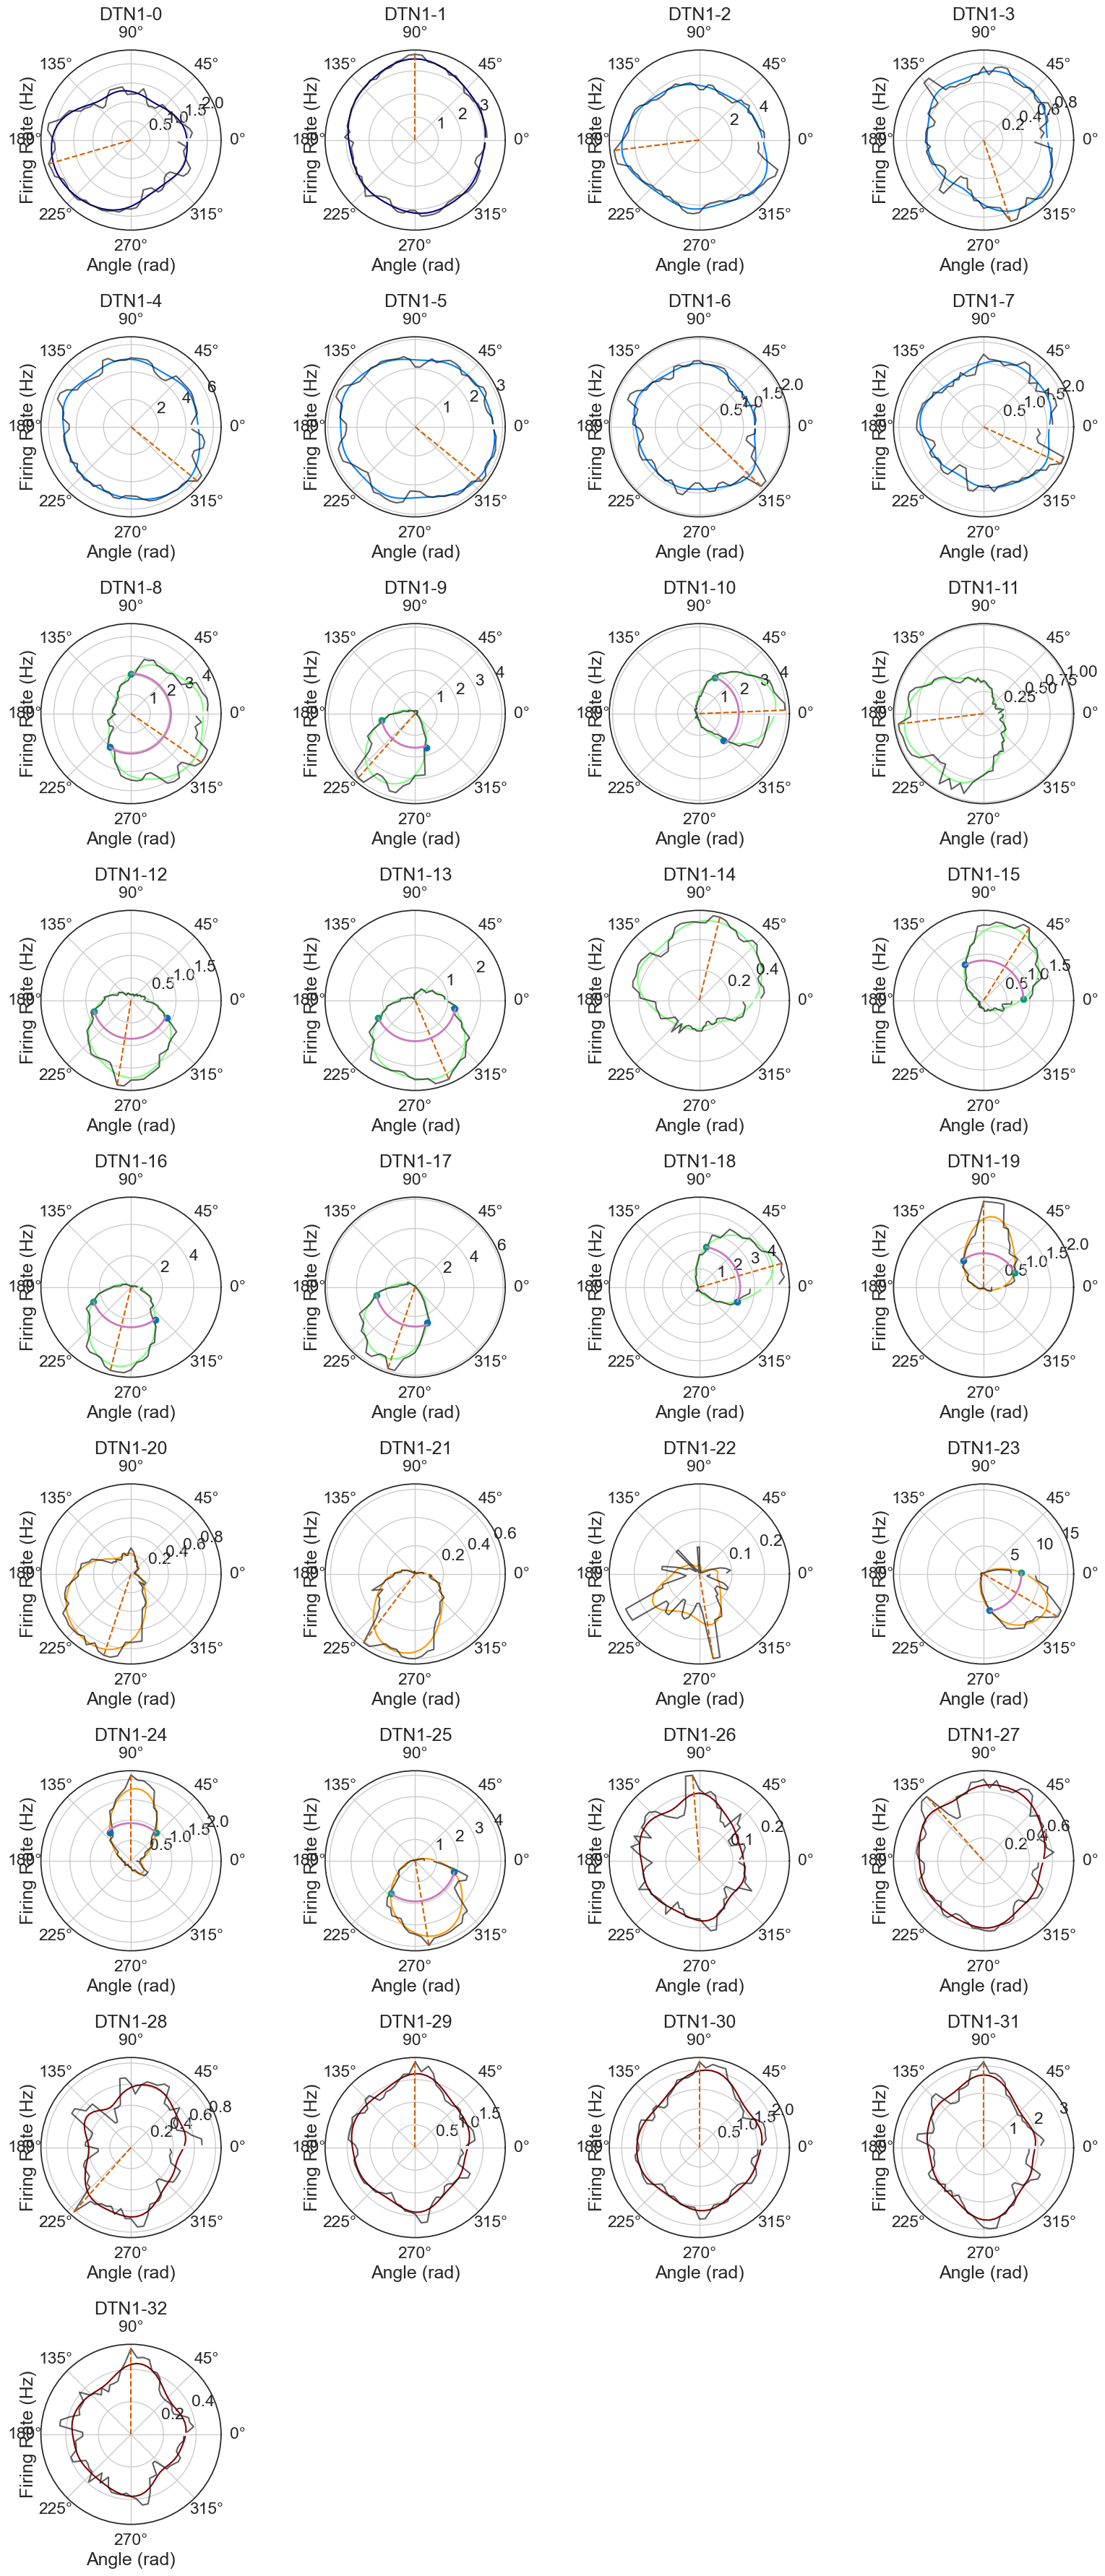

In [865]:
### Plotting

spike_groups = spikes.get_info('group')
# Number of unique groups
unique_groups = set(spike_groups.values)

# Generate a color map for the groups
group_colors = plt.cm.get_cmap('jet', len(unique_groups))  # 'hsv' colormap with as many colors as there are unique groups

# Map each group to a color
group_to_color = {group: group_colors(i) for i, group in enumerate(unique_groups)}

# Convert group colors to a DataFrame for easy lookup
color = pd.DataFrame([group_to_color[spike_groups[i]] for i in spike_groups.keys()],
                        index=spike_groups.keys(), columns=['r', 'g', 'b', 'a'])

num_curves = len(spikes)
num_columns = 4
num_rows = math.ceil(num_curves / num_columns)

# Size per subplot (width, height) in inches
width_per_subplot = 4
height_per_subplot = 4

# Total figure size
total_width = width_per_subplot * num_columns
total_height = height_per_subplot * num_rows
plot=True
if plot==True:
    plt.figure(figsize=(total_width, total_height))
    for i, n in enumerate(spikes.keys()):
        plt.subplot(num_rows, num_columns, i + 1, projection='polar')
        plt.plot(smoothcurves[n], color=color.loc[n])
        plt.plot(tuning_curves[n], color='k', alpha=0.7)
        plt.plot([pref_ang[n], pref_ang[n]], [0, max(max(smoothcurves[n]), max(tuning_curves[n]))], 'r--')  # 'r--' makes the line red and dashed
        if n in hd_labels and hd_labels[n] == 1:
            whm_angles = hd_whm[n]  # Get the WHM angles
            colors_whm = ['g', 'b','y']  # List of colors to cycle through
            for idx, angle in enumerate(whm_angles):
                whm_firing_rate = smoothcurves[n][angle]
                color_whm = colors_whm[idx % len(colors_whm)]  # Cycle through the colors list
                plt.plot(angle, whm_firing_rate, color_whm + 'o')  # Plot with the chosen color
            
            start_angle, end_angle = whm_angles
            start_angle %= 2 * np.pi
            end_angle %= 2 * np.pi
            pref_angle = pref_ang[n] % (2 * np.pi)

            # Find amplitude at start_angle
            start_angle_amplitude = smoothcurves[n].loc[start_angle]

            # Determine the direction for interpolation
            if start_angle < end_angle:
                if start_angle < pref_angle < end_angle:
                    interpolated_angles = np.linspace(start_angle, end_angle, num=100)
                else:
                    interpolated_angles = np.linspace(end_angle, start_angle + 2 * np.pi, num=100)
            else:
                if end_angle < pref_angle < start_angle:
                    interpolated_angles = np.linspace(start_angle, end_angle + 2 * np.pi, num=100)
                else:
                    interpolated_angles = np.linspace(end_angle, start_angle, num=100)

            interpolated_angles = interpolated_angles % (2 * np.pi)
            
            # Set amplitude to that of the start_angle for all points, checking not to exceed smoothcurves' max
            interpolated_amplitudes = np.full_like(interpolated_angles, start_angle_amplitude)
            max_amplitude = smoothcurves[n].max()
            interpolated_amplitudes = np.minimum(interpolated_amplitudes, max_amplitude)

            plt.plot(interpolated_angles, interpolated_amplitudes, 'm-', linewidth=2)

        plt.title(session + '-' + str(n))  # Assume 's' is your titles dictionary
        plt.xlabel("Angle (rad)")
        plt.ylabel("Firing Rate (Hz)")
        #plt.xticks([])
    plt.tight_layout()
    plt.show()

In [732]:
hd_polar_distance1=[]
pref_ang1=[]
for n in hd_polar_distance.keys():
    hd_polar_distance1.append(hd_polar_distance[n])
    pref_ang1.append(pref_ang[n])

In [722]:
hd_polar_distance2=[]
pref_ang2=[]
for n in hd_polar_distance.keys():
    hd_polar_distance2.append(hd_polar_distance[n])
    pref_ang2.append(pref_ang[n])

In [714]:
hd_polar_distance3=[]
pref_ang3=[]
for n in hd_polar_distance.keys():
    hd_polar_distance3.append(hd_polar_distance[n])
    pref_ang3.append(pref_ang[n])

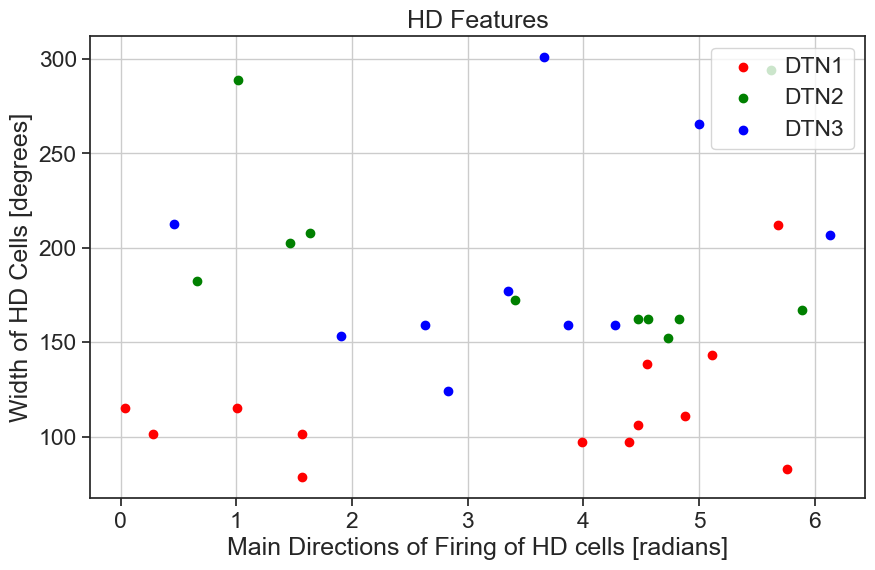

In [733]:
plt.figure(figsize=(10, 6))
plt.scatter(pref_ang1, hd_polar_distance1, marker='o', color='red', label='DTN1')
plt.scatter(pref_ang2, hd_polar_distance2, marker='o', color='green', label='DTN2')
plt.scatter(pref_ang3, hd_polar_distance3, marker='o', color='blue',label='DTN3')
plt.title('HD Features')
plt.xlabel('Main Directions of Firing of HD cells [radians]')
plt.ylabel('Width of HD Cells [degrees]')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

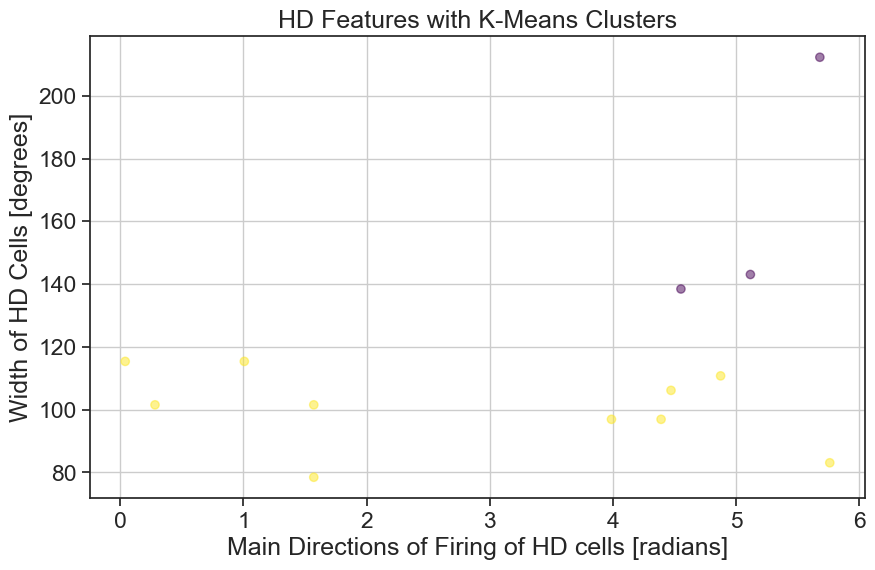

In [785]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Combine the data into a single dataset
#X = np.concatenate((
    #np.column_stack((pref_ang1, hd_polar_distance1)),
    #np.column_stack((pref_ang2, hd_polar_distance2)),
    #np.column_stack((pref_ang3, hd_polar_distance3))
#))

X = np.column_stack((pref_ang1, hd_polar_distance1))

# Standardization
scaler = StandardScaler()
norm = MinMaxScaler()
X_standardized = norm.fit_transform(X)

X_standardized[:,1]=X_standardized[:,1]*2

# Run k-means clustering
k = 2  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42).fit(X_standardized)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plot the original data
plt.figure(figsize=(10, 6))  
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)
#plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5, marker='X')  # Plot centroids
plt.title('HD Features with K-Means Clusters')
plt.xlabel('Main Directions of Firing of HD cells [radians]')
plt.ylabel('Width of HD Cells [degrees]')
plt.grid(True)
plt.show()

In [939]:
hd_group={}

for i in hd_labels.keys():
    if hd_labels[i]==1:
        hd_group[i]=spikes.get_info('group')[i]

print('HD Group:',hd_group)
hd_group_list=np.unique(list(hd_group.values()))
group_to_delete=[]

for i in channels.keys():
    if i not in hd_group_list:
        group_to_delete.append(list(channels[i]))
group_to_delete=[item for sublist in group_to_delete for item in sublist]


txt_writing = "[" + ", ".join(str(item) for item in group_to_delete) + "]"
with open(path +'\\'+ data.basename+ r'_group_to_delete.txt', 'w') as file:
    file.write(txt_writing)

spikes.set_info(HD=pd.Series(hd_labels))
spikes.set_info(HD_type=pd.Series(hd_type))
spikes_hd=spikes.getby_category('HD')[1]

HD Group: {8: 3, 9: 3, 10: 3, 12: 3, 13: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 4, 23: 4, 24: 4, 25: 4}


In [941]:
spikes

  Index    rate    group  location      HD    HD_type
-------  ------  -------  ----------  ----  ---------
      0    1.93        1  DTN            0          0
      1   21.2         1  DTN            0          0
      2    6.27        2  DTN            0          0
      3    2.18        2  DTN            0          0
      4   16.91        2  DTN            0          0
      5    6.81        2  DTN            0          0
      6    4.41        2  DTN            0          0
      7    9.05        2  DTN            0          0
      8    3.85        3  DTN            1          2
      9    7.96        3  DTN            1          1
     10   10.44        3  DTN            1          1
     11    1.98        3  DTN            0          0
     12    1.67        3  DTN            1          2
     13    2.58        3  DTN            1          2
     14    3.12        3  DTN            0          0
     15    4.99        3  DTN            1          1
     16   10.16        3  DT

In [1094]:
ufo_ep, ufo_tsd = loadUFOsV2(path)


ufo_gr = nap.TsGroup({0:ufo_tsd})

#ep = position[['x', 'z']].time_support.loc[[0]]
ep=ufo_gr.time_support

In [1028]:
nap.TsGroup({0:spikes[0]}), ufo_gr

(  Index    rate
 -------  ------
       0    1.93,
   Index    rate
 -------  ------
       0    0.19)

In [1060]:
nap.TsGroup({0:spikes_hd[8]})

  Index    rate
-------  ------
      0    3.85

In [1088]:
position[['x', 'z']].time_support.loc[[0]], ufo_gr.time_support

(   start       end
 0   1.33  15624.35,
        start        end
 0  3971.6459  12498.076)

In [1099]:
ufo_tsd.restrict(position[['x', 'z']].time_support.loc[[0]])

Time (s)
3971.6459
3971.78715
3991.46895
4010.464
4015.6232
...
12495.98115
12496.5357
12497.0641
12497.6682
12498.076
shape: 1638

In [1106]:
position[['x', 'z']].time_support.loc[[0]]

start       end
0   1.33  15624.35

In [1109]:
ufo_gr.time_support

start        end
0  3971.6459  12498.076

In [1111]:
position.restrict(ufo_gr.time_support.loc[[0]])

IndexError: tuple index out of range

In [1097]:
position[['x', 'z']].time_support

start       end
0   1.33  15624.35

In [1132]:
pos=position[['x', 'z']]
ep=ufo_gr.time_support.loc[[0]]
#ep = position[['x', 'z']].time_support.loc[[0]]
bin_size = 0.02

pos = pos#.restrict(ep)
pos2 = pos.bin_average(bin_size)
pos2 = pos2.smooth(1, 100)
speed = np.sqrt(np.sum(np.power(pos2.values[1:, :] - pos2.values[0:-1, :], 2), 1))
t = pos2.index.values[0:-1]+np.diff(pos2.index.values)
speed = nap.Tsd(t = t, d=speed, time_support = ep)

In [1130]:
np.sqrt(np.sum(np.power(pos2.values[1:, :] - pos2.values[0:-1, :], 2), 1))

array([0.10224017, 0.04108681, 0.00553537, ..., 0.00815364, 0.06061844,
       0.16501064])

In [1135]:
pos.t

array([1.330000e+00, 1.340000e+00, 1.350000e+00, ..., 1.562433e+04,
       1.562434e+04, 1.562435e+04])

In [1160]:
spikes_hd.time_support

start           end
0      0.0  13059.999999
1  13060.0  15626.000000

In [1166]:
ufo_gr.value_from(spikes_hd.to_tsd()).time_support

start           end
0      0.0  13059.999999
1  13060.0  15626.000000

In [1530]:
eta_angv = {}
eta_linv = {}
test=[]

ufo_vel = []

ang_lin = []

bin_size = 0.01
ep = position[['x', 'z']].time_support.loc[[0]]
#ep=ufo_gr.time_support.loc[[0]]
lin_velocity = computeLinearVelocity(position[['x', 'z']], ep, bin_size)
lin_velocity = lin_velocity*100.0
ang_velocity = computeAngularVelocity(position['ry'], ep, bin_size)
#ang_velocity = np.abs(ang_velocity)
#ep=ufo_gr.time_support
lin_corr = nap.compute_event_trigger_average(spikes, lin_velocity, bin_size, (-1, 1), ep,time_unit="s")
ang_corr = nap.compute_event_trigger_average(spikes, ang_velocity, bin_size, (-1, 1), ep,time_unit="s")
i=23
eta_linv[i] = lin_corr.loc[i].as_series()
eta_angv[i] = ang_corr.loc[i].as_series()
 

In [1336]:
ang_velocity

Time (s)
---------------  -----------
1.345             0.118112
1.355             0.107926
1.365             0.0837965
1.375             0.0516854
1.385             0.0227402
...
15624.305000295  -0.00266388
15624.315000295  -0.00282022
15624.325000295  -0.00266537
15624.335000295  -0.00226739
15624.345000295  -0.00178674
dtype: float64, shape: (1562301,)

In [1531]:
bin_size = 0.5
n_bins = 50

lin_velocity = computeLinearVelocity(position[['x', 'z']], ep, bin_size)
lin_velocity = lin_velocity*100.0
ang_velocity = computeAngularVelocity(position['ry'], ep, bin_size)
#ang_velocity = np.abs(ang_velocity)

In [1513]:
xb = np.geomspace(0.01, 10.0, n_bins) # linear
yb = np.geomspace(0.01, 2*np.pi, n_bins) # angular

idx = np.vstack((
    np.digitize(lin_velocity.d, xb),
    np.digitize(ang_velocity.d, yb)
    )).T

count = spikes_hd[i].count(ep, bin_size).d.flatten()

hist_ufo_vel = np.zeros((n_bins, n_bins))
for i, (j,k) in enumerate(idx):
    hist_ufo_vel[j-1,k-1] += count[i]

hist_ang_lin = np.zeros((n_bins, n_bins))
for i, (j,k) in enumerate(idx):
    hist_ang_lin[j-1,k-1] += 1.0
hist_ang_lin /= np.sum(hist_ang_lin)
ang_lin.append(hist_ang_lin)

hist_ufo_vel = hist_ufo_vel/(hist_ang_lin+1)
ufo_vel.append(hist_ufo_vel)


In [1066]:
ufo_gr

  Index    rate
-------  ------
      0    0.19

In [1366]:
test=nap.compute_1d_mutual_info(
    tuning_curves, angle, ep=ep, minmax=None, bitssec=False
)

In [1583]:
ang_velocity = computeAngularVelocity(position['ry'], ep, bin_size)
tuning_curves2 = nap.compute_1d_tuning_curves(group=spikes, 
                                            feature=ang_velocity, 
                                            nb_bins=num_bins, 
                                            ep = ttl_epochs,
                                            minmax=(-np.pi, np.pi))

In [1584]:
tuning_curves2

0         1          2    3          4         5         6   \
-3.101316  0.000000  0.000000   0.000000  0.0   0.000000   0.00000   0.00000   
-3.020762  4.000128  6.000192  24.000768  0.0  14.000448  10.00032  10.00032   
-2.940209  0.000000  0.000000   0.000000  0.0   0.000000   0.00000   0.00000   
-2.859655  0.000000  0.000000   0.000000  0.0   0.000000   0.00000   0.00000   
-2.779101  0.000000  0.000000   0.000000  0.0   0.000000   0.00000   0.00000   
...             ...       ...        ...  ...        ...       ...       ...   
 2.779101  0.000000  0.000000   0.000000  0.0   0.000000   0.00000   0.00000   
 2.859655  0.000000  0.000000   0.000000  0.0   0.000000   0.00000   0.00000   
 2.940209  0.000000  0.000000   0.000000  0.0   0.000000   0.00000   0.00000   
 3.020762  0.000000  0.000000   0.000000  0.0   0.000000   0.00000   0.00000   
 3.101316  0.000000  0.000000   0.000000  0.0   0.000000   0.00000   0.00000   

            7    8    9   ...        23        24         25   26   27   28  \
-3.101316  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000  0.0  0.0  0.0   
-3.020762  0.0  0.0  0.0  ...  6.000192  4.000128  28.000896  0.0  0.0  0.0   
-2.940209  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000  0.0  0.0  0.0   
-2.859655  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000  0.0  0.0  0.0   
-2.779101  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000  0.0  0.0  0.0   
...        ...  ...  ...  ...       ...       ...        ...  ...  ...  ...   
 2.779101  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000  0.0  0.0  0.0   
 2.859655  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000  0.0  0.0  0.0   
 2.940209  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000  0.0  0.0  0.0   
 3.020762  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000  0.0  0.0  0.0   
 3.101316  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000  0.0  0.0  0.0   

                 29        30   31   32  
-3.101316  0.000000  0.000000  0.0  0.0  
-3.020762  4.000128  2.000064  0.0  0.0  
-2.940209  0.000000  0.000000  0.0  0.0  
-2.859655  0.000000  0.000000  0.0  0.0  
-2.779101  0.000000  0.000000  0.0  0.0  
...             ...       ...  ...  ...  
 2.779101  0.000000  0.000000  0.0  0.0  
 2.859655  0.000000  0.000000  0.0  0.0  
 2.940209  0.000000  0.000000  0.0  0.0  
 3.020762  0.000000  0.000000  0.0  0.0  
 3.101316  0.000000  0.000000  0.0  0.0  

[78 rows x 33 columns]

In [1565]:
j=8
tmp=tuning_curves2[j]
tmp[tmp != 0]

-2.617994     6.000192
-2.456887     6.000192
-2.376333    19.600627
-2.295779    14.000448
-2.215226    17.333888
               ...    
 2.134672     4.000128
 2.215226     4.000128
 2.295779     4.000128
 2.376333     6.000192
 2.456887     4.000128
Name: 8, Length: 62, dtype: float64

In [1585]:
for _,j in enumerate(tuning_curves2):
    tmp=tuning_curves2[j]
    tuning_curves2[j]=tmp[tmp != 0].dropna()

In [1560]:
for _,j in enumerate(tuning_curves2):
    print(j)

8
9
10
12
13
15
16
17
18
19
23
24
25


In [1587]:
tuning_curves2.dropna()

0          1          2         3          4          5   \
-1.731904  6.182016   9.818496   8.727552  1.636416  14.545920   6.182016   
-1.248582  5.877739  10.000320   9.020697  1.755158  11.102396   5.020569   
-1.087474  7.397062  10.095561  10.349538  2.571511  14.794124   7.778027   
-1.006921  6.841128  10.159416  10.454880  2.363712  14.273184   6.704760   
-0.926367  7.029928  11.901371  10.554793  2.613945  13.960843   6.713086   
-0.845813  7.062726   9.687810   8.469021  2.375076  13.906695   6.937722   
-0.765260  7.493391  10.205806   7.972858  1.849374  15.877220   7.370099   
-0.684706  6.347621  11.042607  10.094220  2.507122  14.873715   6.450911   
-0.604152  6.623868  10.172369  11.355202  2.376420  15.301565   7.570135   
-0.523599  6.217590   9.556828  10.974264  2.034848  13.548260   6.391509   
-0.443045  7.264232  10.096323   9.696310  2.208071  16.480527   7.344235   
-0.362491  6.729857  10.319549  10.964520  2.716699  16.469582   6.879699   
-0.281938  6.052672  10.151928  13.359028  2.209983  14.834294   6.694092   
-0.201384  5.913858  10.499137  11.971606  2.067212  15.156360   6.901900   
-0.120830  4.300138  10.474409  10.548486  1.740796  14.652321   7.885438   
-0.040277  2.420246  10.671083  10.981253  2.110075  11.945378   8.266116   
 0.040277  3.075867  10.031829  12.348482  2.013568  14.350047   8.390366   
 0.120830  4.865634  10.421727  13.925891  2.103795  17.835255   8.502703   
 0.201384  5.661051  10.582947  15.104831  2.373989  19.326706   9.091595   
 0.281938  5.586992   9.943175  14.576291  2.224247  19.073138   9.551954   
 0.362491  6.166864  10.228105  14.594912  2.366742  21.456242   9.516971   
 0.443045  6.476092  10.399047  15.781856  2.656034  20.347918   9.672335   
 0.523599  6.087531   9.275406  15.677358  1.965128  22.140447  10.664097   
 0.604152  6.845674  10.863984  17.018727  2.181888  21.055219   9.654854   
 0.684706  5.946714  10.182144  17.262585  2.288843  20.834891   9.454848   
 0.765260  7.049871  11.035814  18.213349  2.340500  22.114183  11.702502   
 0.845813  6.470795  10.605381  16.588766  2.403438  25.378964  11.227250   
 0.926367  6.307894  10.346485  20.981441  2.211609  21.558382  10.923427   
 1.087474  6.436570  11.454912  17.527834  2.218253  23.382567  11.309453   
 1.168028  6.920221  11.400365  19.640629  2.720087  26.200839  12.200390   

                 6         7          8         9   ...         23        24  \
-1.731904  8.909376  4.000128   8.182080  6.727488  ...  19.818816  4.545600   
-1.248582  2.898052  3.347046   9.061515  2.000064  ...  25.347750  1.632705   
-1.087474  4.857298  3.968381  11.809902  4.127116  ...  21.968957  2.349282   
-1.006921  3.909216  4.795608   8.500272  2.522808  ...  12.591312  2.295528   
-0.926367  5.802166  4.633812  12.812291  3.663484  ...  23.466098  2.633748   
-0.845813  3.171977  3.640742  10.453460  4.031379  ...  19.141238  2.421953   
-0.765260  4.835771  4.109721   8.972890  4.178216  ...  14.219633  2.424735   
-0.684706  4.216097  4.676206  11.211626  4.375727  ...  16.939509  2.338103   
-0.604152  3.860339  4.774346   8.441130  3.408711  ...  10.097097  2.752776   
-0.523599  3.617507  4.382749   9.669875  4.574059  ...  13.574347  2.052240   
-0.443045  3.488112  4.528145   8.600275  3.304106  ...  12.656405  2.080067   
-0.362491  3.211829  4.110881  10.058954  3.140166  ...  12.671415  2.390956   
-0.281938  3.574458  4.530757   8.437588  2.886390  ...  10.735037  2.093361   
-0.201384  4.206370  4.733964   9.640596  3.578052  ...  10.772527  2.182324   
-0.120830  4.948307  4.481625   8.296562  3.337144  ...   7.974329  1.718574   
-0.040277  4.284324  5.266784   5.920740  3.057393  ...   5.156773  1.422505   
 0.040277  4.205686  5.183962   6.372297  2.618238  ...   7.944740  1.437405   
 0.120830  5.082821  4.917499   7.582090  2.651625  ...   7.685821  1.974131   
 0.201384  5.378433  5.482784   9.226382  2.413121  ...   8.935069  2.313118   
 0.281938  4.866090  4.685864

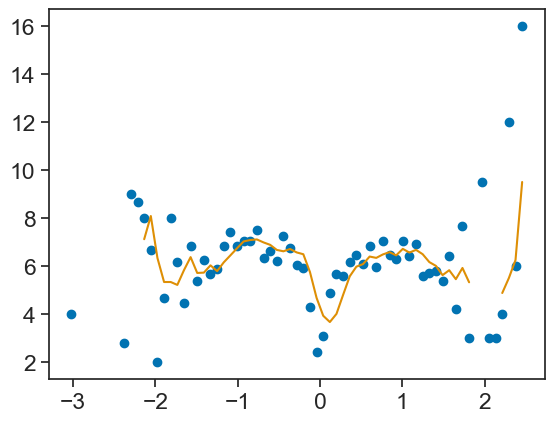

In [1609]:
i=0
tmp = tuning_curves2 - tuning_curves2.mean()
tmp = tmp / tmp.std()
plt.plot(tuning_curves2[i],'o')
plt.plot(tuning_curves2[i].rolling(window=4).mean())
plt.show()

In [1601]:
tuning_curves2[i].values

array([        nan,  6.00019204,         nan,         nan,         nan,
               nan,         nan,         nan,         nan, 27.20087057,
       88.00281654, 87.33612854,         nan, 40.66796825,  0.500016  ,
        8.66694405, 45.77924295, 19.81881612, 26.09174416, 24.2113012 ,
       23.36438414, 23.88311732, 17.33388811, 25.34775003, 19.26215495,
       21.96895709, 12.59131208, 23.46609757, 19.14123762, 14.21963318,
       16.93950929, 10.09709735, 13.57434749, 12.65640507, 12.67141532,
       10.73503745, 10.77252703,  7.97432929,  5.15677314,  7.94474039,
        7.68582135,  8.93506858,  9.69261791, 11.87815794,  9.69805958,
        7.50242352, 10.04577606,  8.82381182, 10.62445351,  9.74821115,
        9.48107267, 12.74399762,  8.03662085,  9.9203175 , 12.33372808,
        8.71456462, 18.10057931, 21.23144875,  4.00012802, 14.88936542,
       21.66736013,  2.00006401,         nan, 20.50065613, 27.00086417,
               nan, 18.00057611,         nan, 18.00057611,  6.00

In [1625]:
tmp=tuning_curves2[i].rolling(window=4).mean().dropna()
tmp=tmp[(tmp.index > -1.5) & (tmp.index < 1.5)]
tmp = (tmp - tmp.mean()) / tmp.std()
np.mean(tmp[tmp.index > 0].values) - np.mean(tmp[tmp.index < 0].values)



-0.6486216307114546

In [1610]:
from scipy.stats import skew

tc_angv_skew=skew(tuning_curves2[i].dropna())

tc_angv_skew

1.464850335125253

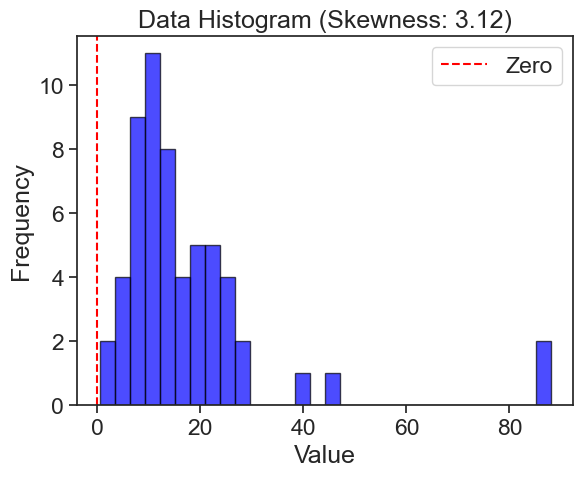

In [1606]:
from scipy.stats import skew

tc_angv_skew=skew(tuning_curves2[i].dropna())

plt.hist(tuning_curves2[i], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='Zero')
plt.title(f"Data Histogram (Skewness: {tc_angv_skew:.2f})")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

NameError: name 'data_skewness' is not defined

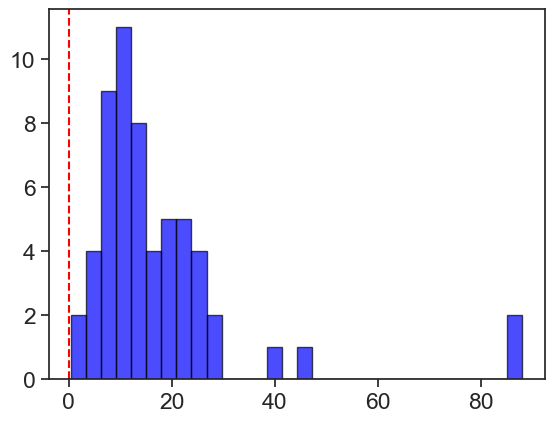

In [1589]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

eta_linv = pd.DataFrame.from_dict(eta_linv)
eta_angv = pd.DataFrame.from_dict(eta_angv)

ufo_vel = np.array(ufo_vel)
ang_lin = np.array(ang_lin)

plt.figure(figsize = (16, 12))

gs = GridSpec(2,2)

plt.subplot(gs[0,0])
tmp = eta_linv - eta_linv.mean()
tmp = tmp / tmp.std()
plt.plot(tmp, color='grey', alpha=0.8, linewidth=0.8)
plt.plot(tmp.mean(1), linewidth=4)
plt.title("Linear speed")
plt.axvline(0.0)
plt.ylabel("Z")

plt.subplot(gs[0,1])
tmp = eta_angv - eta_angv.mean()
tmp = tmp / tmp.std()
plt.plot(tmp, color='grey', alpha=0.8, linewidth=0.8)
plt.plot(tmp.mean(1), linewidth=4)
plt.title("Angular speed")
plt.axvline(0.0)
plt.ylabel("Z")

gs2 = GridSpecFromSubplotSpec(2, 2, gs[1,0], width_ratios=[0.8,0.4], height_ratios=[0.4,0.8])

plt.subplot(gs2[0,0])
tmp1 = ufo_vel.mean(0).mean(0)[0:-1]
plt.semilogx(xb[0:-1], tmp1/tmp1.sum())
tmp2 = ang_lin.mean(0).mean(0)[0:-1]
plt.semilogx(xb[0:-1], tmp2/tmp2.sum())

plt.subplot(gs2[1,0])
plt.imshow(ufo_vel.mean(0)[0:-1,0:-1], cmap='jet', origin='lower', aspect='auto')
plt.title("UFO")
plt.xlabel("Linear (cm/s)")
plt.ylabel("Angular (rad/s)")
plt.xticks(np.arange(0, ufo_vel.shape[1], 10), np.round(xb[::10], 3))
plt.yticks(np.arange(0, ufo_vel.shape[2], 10), np.round(yb[::10], 3))

plt.subplot(gs2[1,1])
tmp1 = ufo_vel.mean(0).mean(1)[0:-1]
plt.semilogy(tmp1/tmp1.sum(), yb[0:-1])
plt.tmp2 = ang_lin.mean(0).mean(1)[0:-1]
plt.semilogy(tmp2/tmp2.sum(), yb[0:-1])

plt.subplot(gs[1,1])

plt.imshow(ang_lin.mean(0)[0:-1,0:-1], cmap='jet', origin='lower', aspect='auto')
plt.title("occupancy")
plt.xlabel("Linear (cm/s)")
plt.ylabel("Angular (rad/s)")
plt.xticks(np.arange(0, ufo_vel.shape[1], 10), np.round(xb[::10], 3))
plt.yticks(np.arange(0, ufo_vel.shape[2], 10), np.round(yb[::10], 3))


plt.tight_layout()
plt.show()

In [1458]:
ufo_ep

start          end
0      3971.64195   3971.64885
1      3971.78525   3971.78890
2      3991.46425   3991.47265
3      4010.46290   4010.46505
4      4015.61860   4015.62780
...           ...          ...
1633  12495.97740  12495.98370
1634  12496.53070  12496.53920
1635  12497.06055  12497.06760
1636  12497.66565  12497.67090
1637  12498.07390  12498.07775

[1638 rows x 2 columns]

In [1480]:
bin_centers

array([1.49518652e-02, 1.86659201e-02, 2.33025492e-02, 2.90909206e-02,
       3.63171280e-02, 4.53383308e-02, 5.66004075e-02, 7.06599928e-02,
       8.82119901e-02, 1.10123917e-01, 1.37478784e-01, 1.71628621e-01,
       2.14261304e-01, 2.67483979e-01, 3.33927207e-01, 4.16874986e-01,
       5.20427057e-01, 6.49701543e-01, 8.11087912e-01, 1.01256278e+00,
       1.26408417e+00, 1.57808366e+00, 1.97008087e+00, 2.45945049e+00,
       3.07037990e+00, 3.83306466e+00, 4.78520091e+00, 5.97384854e+00,
       7.45775717e+00, 9.31026986e+00, 1.16229482e+01, 1.45100975e+01,
       1.81144170e+01, 2.26140524e+01, 2.82314006e+01, 3.52441025e+01,
       4.39987650e+01, 5.49280924e+01, 6.85722734e+01, 8.56056795e+01,
       1.06870197e+02, 1.33416837e+02, 1.66557683e+02, 2.07930742e+02,
       2.59580900e+02, 3.24060997e+02, 4.04558002e+02, 5.05050524e+02,
       6.30505468e+02])

In [1504]:
ufo_ep['start'].values

array([ 3971.64195,  3971.78525,  3991.46425, ..., 12497.06055,
       12497.66565, 12498.0739 ])

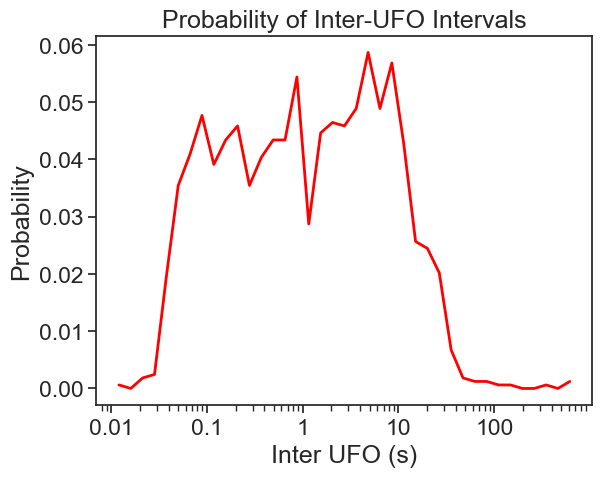

In [1507]:
from matplotlib.ticker import LogLocator

intervals=np.diff(ufo_ep['start'].values)

# Logarithmically spaced bins
num_bins = int(np.sqrt(len(intervals)))  # Adjust the number of bins as necessary
bin_edges = np.logspace(np.log10(min(intervals)), np.log10(max(intervals)), num_bins)

# Compute histogram without density
hist, bin_edges = np.histogram(intervals, bins=bin_edges, density=True)

bin_width = np.diff(bin_edges)
probabilities = hist * bin_width

# Compute bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the probabilities as a red line
plt.plot(bin_centers, probabilities, color='red', linewidth=2)

# Set the scale of the x-axis to logarithmic
plt.xscale('log')

# Define the ticks and labels you want to use
desired_ticks = [0.01, 0.1, 1, 10, 100]
desired_labels = ['0.01', '0.1', '1', '10', '100']

# Set the x-axis ticks and labels
plt.xticks(desired_ticks, desired_labels)

# Label the plot
plt.xlabel('Inter UFO (s)')
plt.ylabel('Probability')
plt.title('Probability of Inter-UFO Intervals')

# Set y-axis limits to 0 and 1
#plt.ylim(0, 1)

# Show the plot
plt.show()

In [834]:
sorted_dict = np.argsort(np.argmax(spikes_hd.get_info('HD_type').values, 0))
sorted_dict

array([0], dtype=int64)

In [849]:
hd_type_order = dict(sorted(spikes_hd.get_info('HD_type').items(), key=lambda item: item[1]))
spikes_hd.get_info('HD_type').sort_values()

9     1
10    1
15    1
16    1
17    1
18    1
19    1
23    1
24    1
25    1
8     2
12    2
13    2
Name: HD_type, dtype: int64

In [844]:
def z_score_normalize(series):
        mean_val = series.mean(axis=0)
        std_val = series.std(axis=0)
        #std_val[std_val==0]=1
        z_scores = (series - mean_val) / std_val
        return z_scores

In [845]:
ufo_ep, ufo_tsd = loadUFOsV2(path)
cc_hd = nap.compute_eventcorrelogram(spikes_hd, ufo_tsd, 0.001, 0.1, None, norm=False)
z_cc_hd=z_score_normalize(cc_hd)
z_ccs_hd=z_cc_hd.loc[-0.1:0.1]
sorted_hd_types = spikes_hd.get_info('HD_type').sort_values()
sorted_indices = sorted_hd_types.index
z_ccs_hd_sorted = z_ccs_hd.loc[:, sorted_indices]

In [851]:
sorted_hd_types = spikes_hd.get_info('HD_type').sort_values()
sorted_indices = sorted_hd_types.index
z_ccs_hd_sorted = z_ccs_hd.loc[:, sorted_indices]
limit_index = sorted_hd_types[sorted_hd_types == 1].index[-1]

limit_index

25

In [864]:
limit_index = sorted_hd_types[sorted_hd_types == 1].index[-1]

limit_index, sorted_hd_types.index.get_loc(limit_index)

(25, 9)

In [21]:
spikes.get_info('group').index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='int32')

In [330]:
spikes_groups=spikes.get_info('group')

print(np.unique(spikes_groups.values))

[0 1 2 5 6 7]


In [6]:
ufo_ep, ufo_tsd = loadUFOsV2(path)

In [7]:
data.load_neurosuite_xml(data.path)
channels = data.group_to_channel
filename = data.basename + ".dat" 
fp, timestep = get_memory_map(os.path.join(data.path, filename), data.nChannels)

sign_channels = channels[ufo_channels_nb[session][0]]
ctrl_channels = channels[ufo_channels_nb[session][1]]

In [16]:
lfp_sign = data.load_lfp(channel=list(sign_channels),extension='.dat',frequency=fs)
lfp_sign2=lfp_sign.restrict(ufo_ep)

In [8]:
hd_labels={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 1, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0}

In [9]:
spikes.set_info(HD=pd.Series(hd_labels))

In [10]:
spikes_hd=spikes.getby_category('HD')[1]

In [266]:
spikes

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    1
18    0
19    0
20    0
21    0
22    0
23    1
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
Name: HD, dtype: int64

In [307]:
ufo_peth={}

In [315]:
ufo_peth=nap.compute_perievent(spikes_hd[17],ufo_tsd,minmax=(-0.25, 0.25))
ufo_peth2=nap.compute_perievent(spikes_hd[16],ufo_tsd,minmax=(-0.25, 0.25))
ufo_peth3=nap.compute_perievent(spikes_hd[23],ufo_tsd,minmax=(-0.25, 0.25))
ctrl_peth=nap.compute_perievent(spikes[1],ufo_tsd,minmax=(-0.25, 0.25))

In [312]:
for j,(index, peth) in enumerate(ufo_peth.items()):
    print(index)
    for i, n in enumerate(peth):
        print(n)

17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276

In [294]:
for i, (_, peth) in enumerate(ufo_peth.items()):
    print(peth)

  Index    rate    ref_times
-------  ------  -----------
      0      22      3971.65
      1      18      3971.79
      2      18      3991.47
      3      20      4010.46
      4      20      4015.62
      5      20      4026.64
      6      20      4028.63
      7      36      4030.05
      8      18      4031.14
      9      18      4035.44
     10      20      4039.8
     11      18      4041.16
     12      20      4041.57
     13      16      4046.14
     14      12      4054.24
     15       8      4054.34
     16      12      4055.39
     17      26      4059.5
     18      22      4060.19
     19      16      4060.24
     20      14      4068.73
     21      10      4104.63
     22      10      4108.32
     23      22      4108.68
     24      22      4108.75
     25      26      4108.83
     26      16      4154.83
     27      16      4159.11
     28      26      4159.71
     29       8      4161.56
     30      18      4162.51
     31      20      4173.45
     32      22 

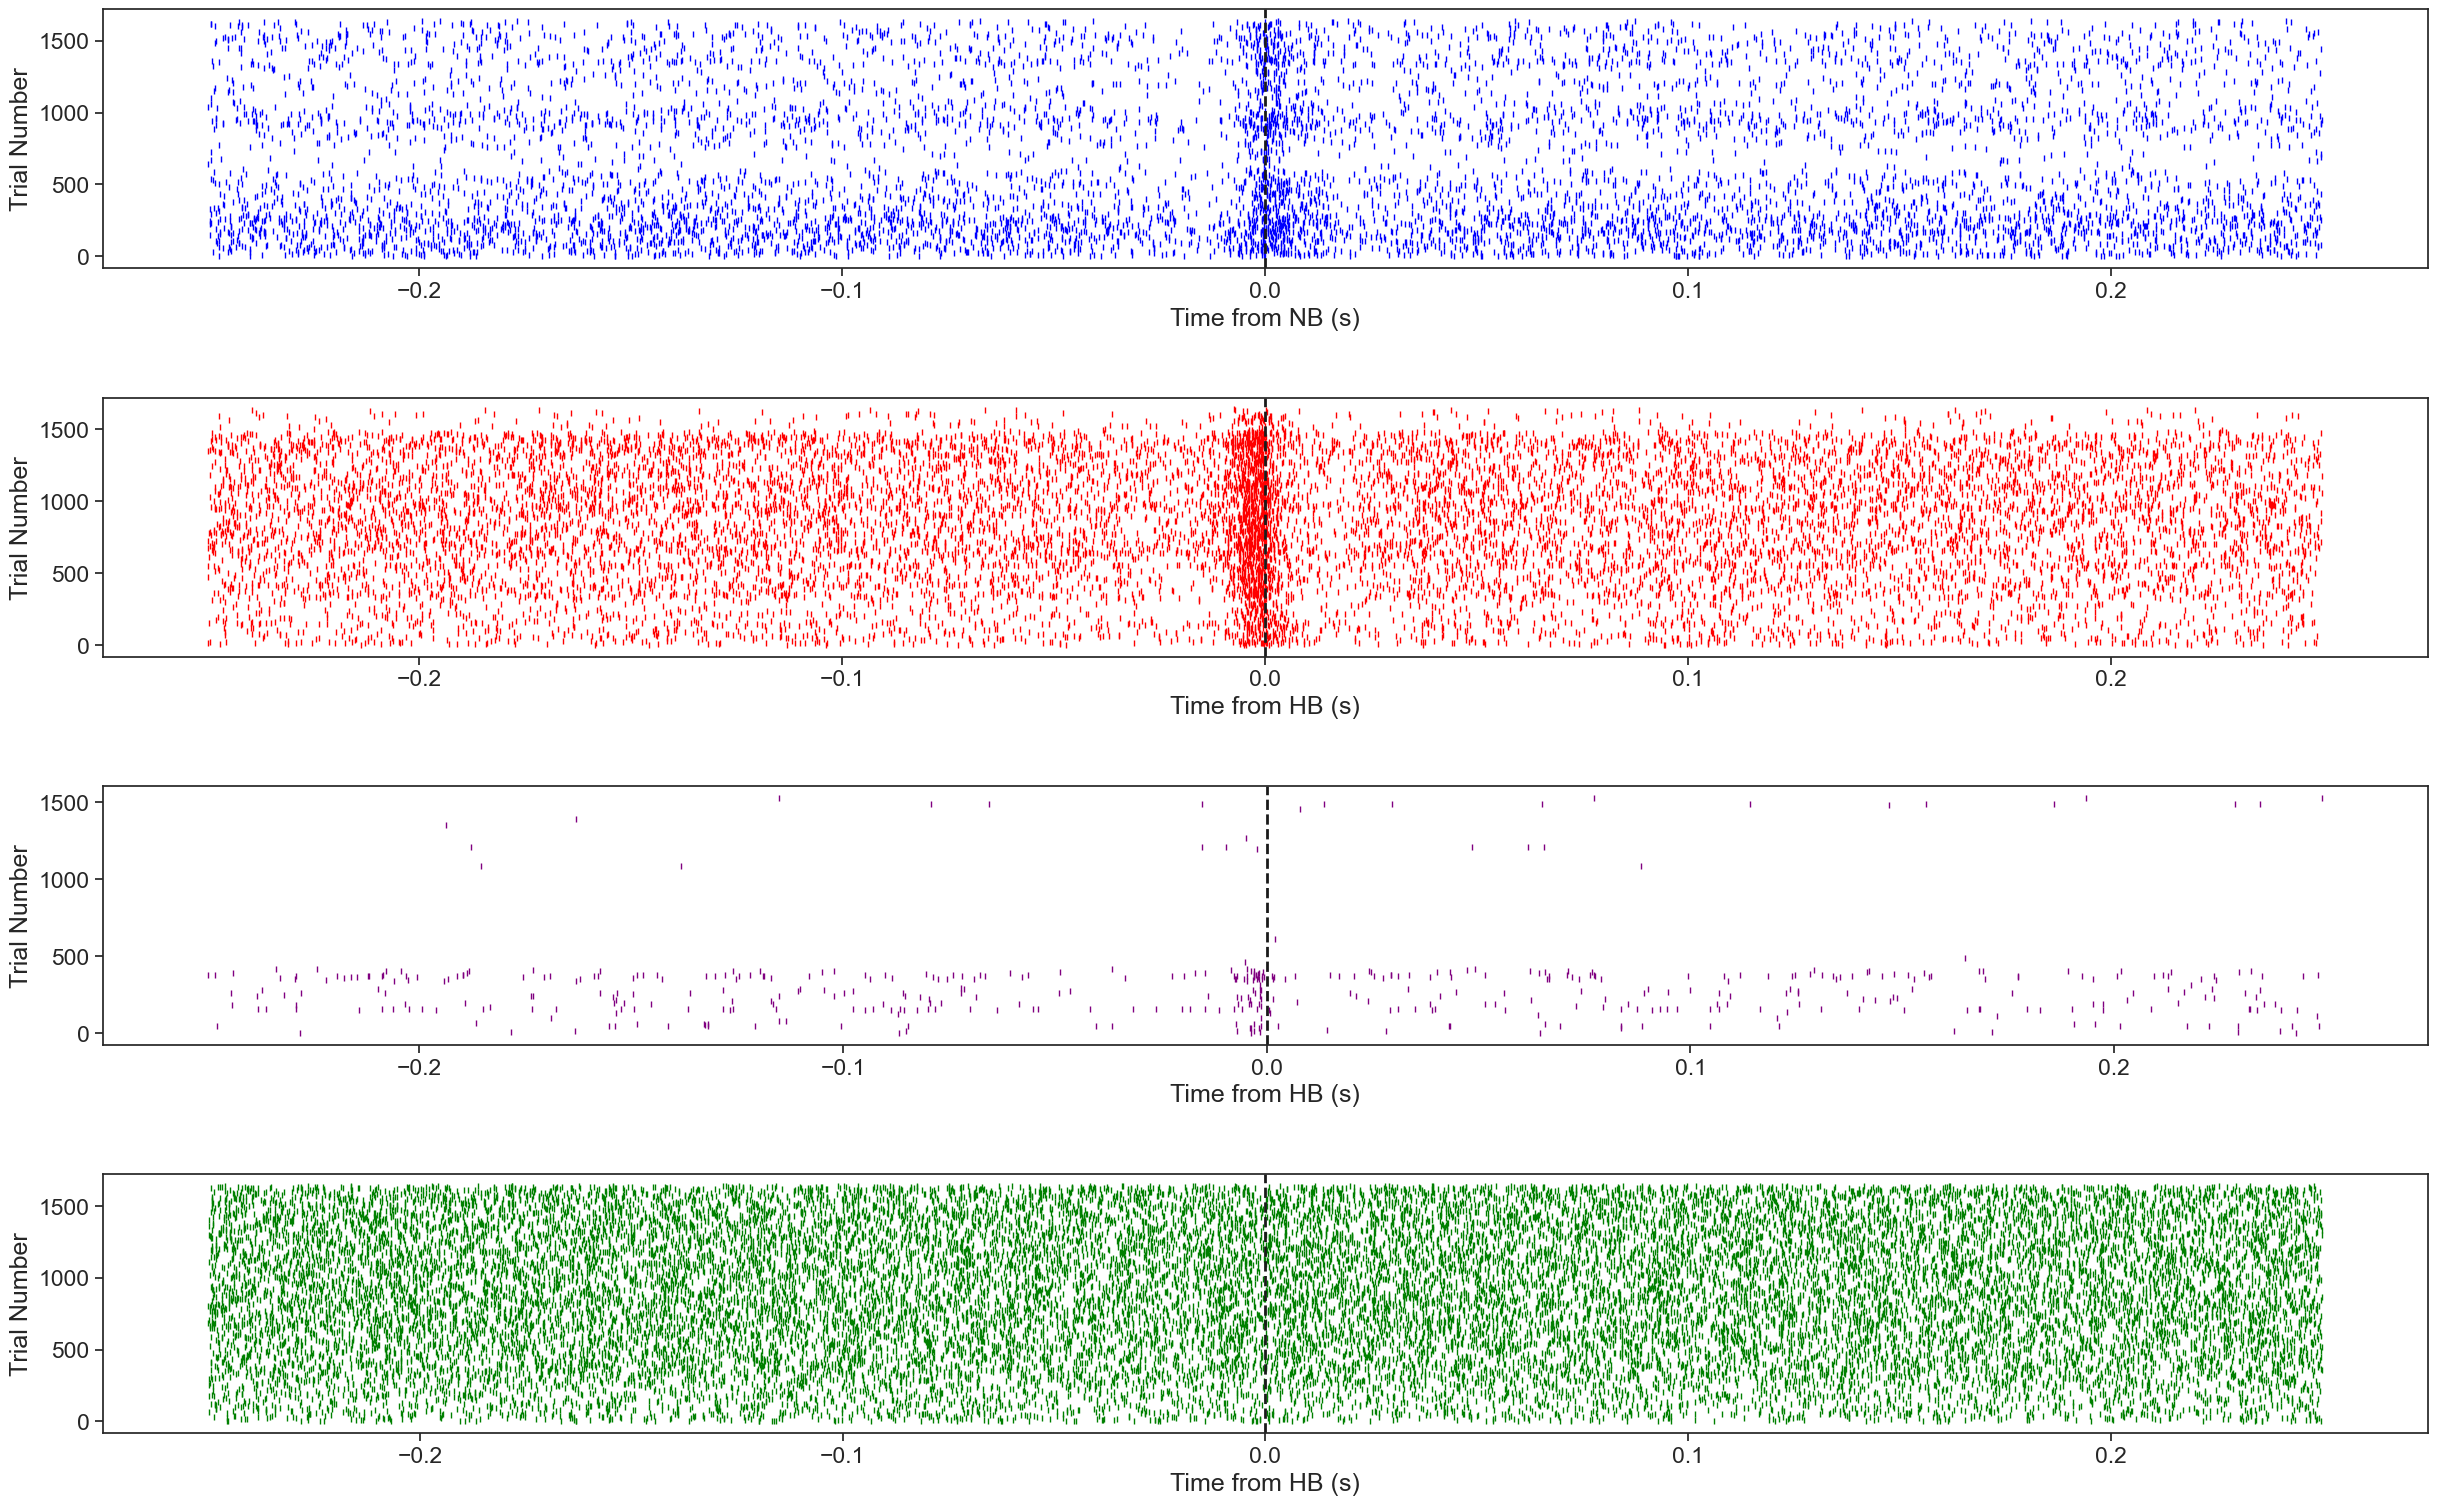

In [318]:
plt.figure(figsize =(30,16))
plt.subplot(411)  # Plot the figures in 2 rows
for i, n in enumerate(ufo_peth):
    plt.plot(
        ufo_peth[n].as_units("s").fillna(i),
        "|",
        color='blue',
        markersize=4,
    )  # Plot PETH
plt.axvline(0, linewidth=2, color="k", linestyle="--")  # Plot a line at t = 0
plt.xlabel("Time from NB (s)")  # Time from boundary in seconds, on X-axis
plt.ylabel("Trial Number")  # Trial number on Y-axis

plt.subplot(412)
for i, n in enumerate(ufo_peth2):
    plt.plot(
        ufo_peth2[n].as_units("s").fillna(i),
        "|",
        color='red',
        markersize=4,
    )  # Plot PETH
plt.axvline(0, linewidth=2, color="k", linestyle="--")  # Plot a line at t = 0
plt.xlabel("Time from HB (s)")  # Time from boundary in seconds, on X-axis
plt.ylabel("Trial Number")  # Trial number on Y-axis

plt.subplot(413)
for i, n in enumerate(ufo_peth2):
    plt.plot(
        ufo_peth3[n].as_units("s").fillna(i),
        "|",
        color='purple',
        markersize=4,
    )  # Plot PETH
plt.axvline(0, linewidth=2, color="k", linestyle="--")  # Plot a line at t = 0
plt.xlabel("Time from HB (s)")  # Time from boundary in seconds, on X-axis
plt.ylabel("Trial Number")  # Trial number on Y-axis

plt.subplot(414)
for i, n in enumerate(ufo_peth2):
    plt.plot(
        ctrl_peth[n].as_units("s").fillna(i),
        "|",
        color='green',
        markersize=4,
    )  # Plot PETH
plt.axvline(0, linewidth=2, color="k", linestyle="--")  # Plot a line at t = 0
plt.xlabel("Time from HB (s)")  # Time from boundary in seconds, on X-axis
plt.ylabel("Trial Number")  # Trial number on Y-axis

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=1)

In [296]:
spikes=data.spikes
spikes.set_info(HD=pd.Series(hd_labels))
spikes_hd=spikes.getby_category('HD')[1]

spikes_hd

  Index    rate    group  location      HD
-------  ------  -------  ----------  ----
     16   10.16        3  DTN            1
     17    5.62        3  DTN            1
     23    4.15        4  DTN            1

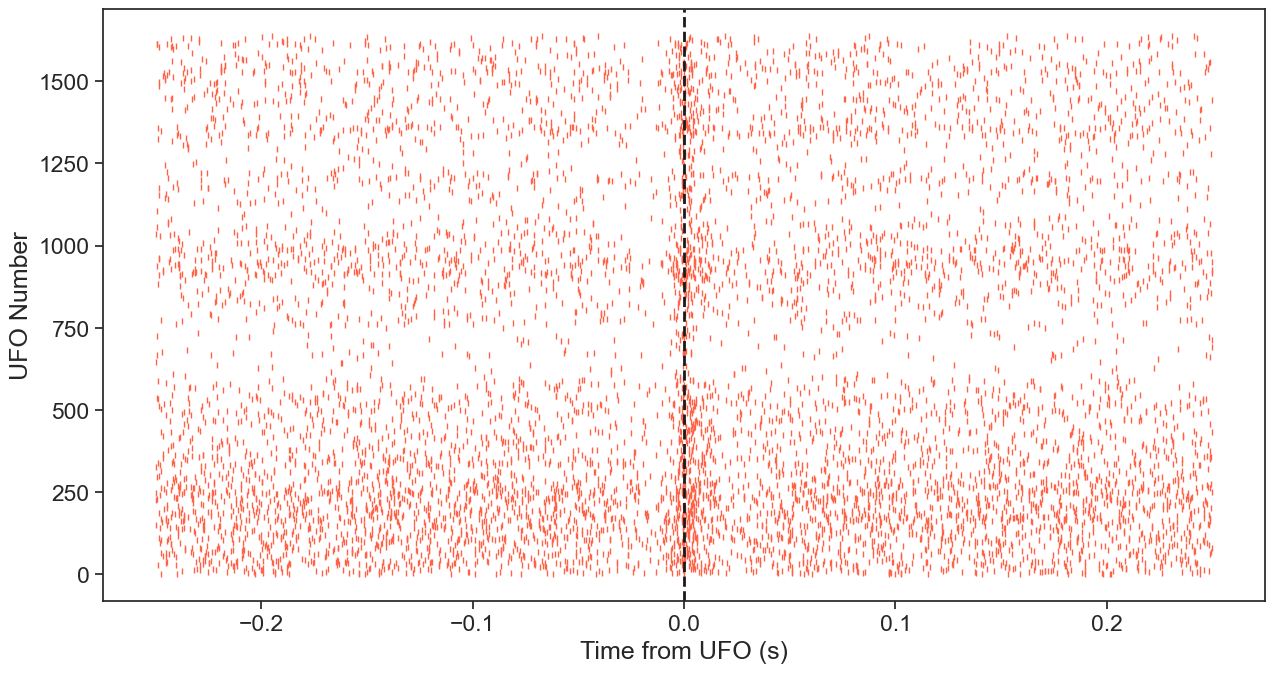

In [67]:
plt.figure(figsize =(15,8))
for i, n in enumerate(ufo_peth):
    plt.plot(
        ufo_peth[n].as_units("s").fillna(i),
        "|",
        color=[255 / 255, 99 / 255, 71 / 255],
        markersize=4,
    )  # Plot PETH
plt.axvline(0, linewidth=2, color="k", linestyle="--")  # Plot a line at t = 0
#plt.yticks([0, 30])  # Set ticks on Y-axis
#plt.gca().set_yticklabels(["1", "30"])  # Label the ticks
plt.xlabel("Time from UFO (s)")  # Time from boundary in seconds, on X-axis
plt.ylabel("UFO Number")  # Trial number on Y-axis
plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.85)

In [68]:
bin_size = 0.01  # 200ms bin size
step_size = 0.001  # 10ms step size, to make overlapping bins
winsize = int(bin_size / step_size)  # Window size

counts_ufo = ufo_peth.count(step_size, time_units='s')  # Spike counts binned in 10ms steps, for HB trials
counts_ufo2 = ufo_peth2.count(step_size, time_units='s')
counts_ufo3 = ufo_peth3.count(step_size, time_units='s')
counts_ctrl = ctrl_peth.count(step_size, time_units='s')

counts_ufo = (
    counts_ufo.as_dataframe()
    .rolling(winsize, win_type="gaussian", min_periods=1, center=True, axis=0)
    .mean(std=0.2 * winsize)
)

counts_ufo2 = (
    counts_ufo2.as_dataframe()
    .rolling(winsize, win_type="gaussian", min_periods=1, center=True, axis=0)
    .mean(std=0.2 * winsize)
)

counts_ufo3 = (
    counts_ufo3.as_dataframe()
    .rolling(winsize, win_type="gaussian", min_periods=1, center=True, axis=0)
    .mean(std=0.2 * winsize)
)

counts_ctrl = (
    counts_ctrl.as_dataframe()
    .rolling(winsize, win_type="gaussian", min_periods=1, center=True, axis=0)
    .mean(std=0.2 * winsize)
)

fr_ufo = (counts_ufo * winsize)/bin_size
fr_ufo2 = (counts_ufo2 * winsize)/bin_size
fr_ufo3 = (counts_ufo3 * winsize)/bin_size
fr_ctrl = (counts_ctrl * winsize)/bin_size

meanfr_ufo = fr_ufo.mean(axis=1)
meanfr_ufo2 = fr_ufo2.mean(axis=1)
meanfr_ufo3 = fr_ufo3.mean(axis=1)
meanfr_ctrl = fr_ctrl.mean(axis=1)

error_ufo = fr_ufo.sem(axis=1)
error_ufo2 = fr_ufo2.sem(axis=1)
error_ufo3 = fr_ufo3.sem(axis=1)
error_ctrl = fr_ctrl.sem(axis=1)

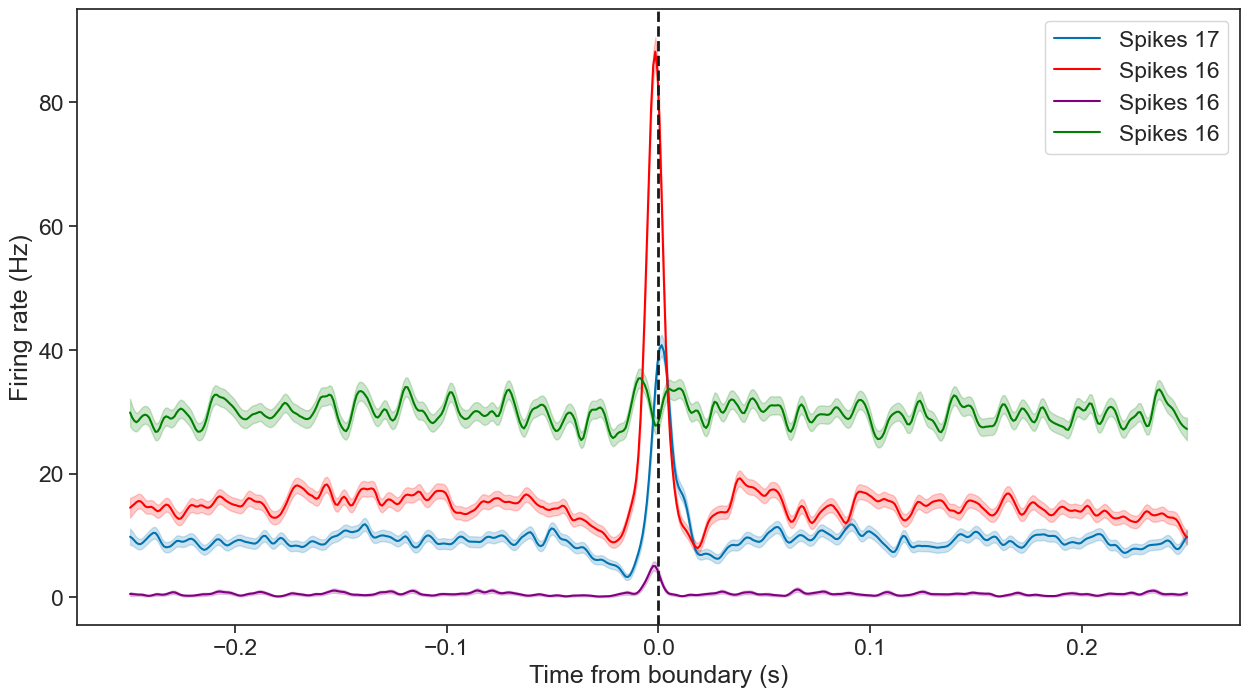

In [69]:
plt.figure(figsize =(15,8))
plt.plot(
    meanfr_ufo, color='b', label="Spikes 17"
)  # Plot mean firing rate for NB trials

# Plot SEM for NB trials
plt.fill_between(
    meanfr_ufo.index.values,
    meanfr_ufo.values - error_ufo,
    meanfr_ufo.values + error_ufo,
    color='b',
    alpha=0.2,
)

plt.plot(
    meanfr_ufo2, color='red', label="Spikes 16"
)  # Plot mean firing rate for HB trials

# Plot SEM for NB trials
plt.fill_between(
    meanfr_ufo2.index.values,
    meanfr_ufo2.values - error_ufo2,
    meanfr_ufo2.values + error_ufo2,
    color='red',
    alpha=0.2,
)

plt.plot(
    meanfr_ufo3, color='purple', label="Spikes 16"
)  # Plot mean firing rate for HB trials

# Plot SEM for NB trials
plt.fill_between(
    meanfr_ufo3.index.values,
    meanfr_ufo3.values - error_ufo3,
    meanfr_ufo3.values + error_ufo3,
    color='purple',
    alpha=0.2,
)

plt.plot(
    meanfr_ctrl, color='green', label="Spikes 16"
)  # Plot mean firing rate for HB trials

# Plot SEM for NB trials
plt.fill_between(
    meanfr_ctrl.index.values,
    meanfr_ctrl.values - error_ctrl,
    meanfr_ctrl.values + error_ctrl,
    color='green',
    alpha=0.2,
)

plt.axvline(0, linewidth=2, color="k", linestyle="--")  # Plot a line at t = 0
plt.xlabel("Time from boundary (s)")  # Time from boundary in seconds, on X-axis
plt.ylabel("Firing rate (Hz)")  # Firing rate in Hz on Y-axis
plt.legend(loc="upper right")

In [48]:
spikes_hd

  Index    rate    group  location      HD
-------  ------  -------  ----------  ----
     16   10.16        3  DTN            1
     17    5.62        3  DTN            1
     23    4.15        4  DTN            1

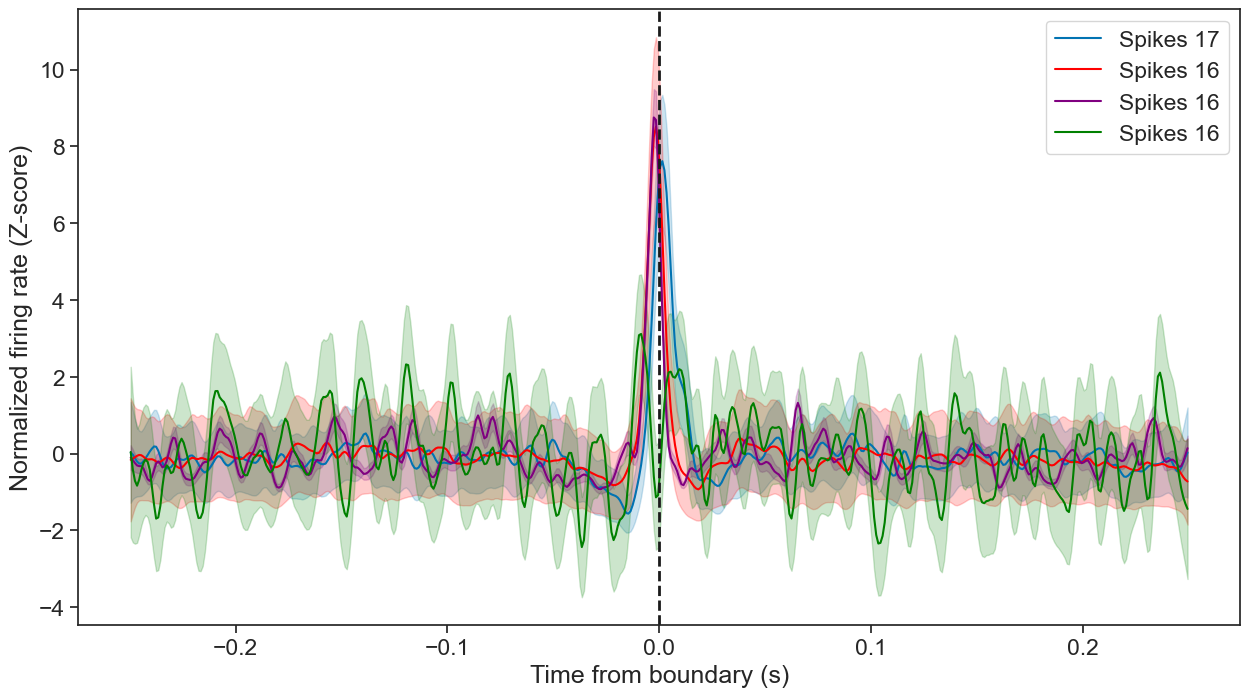

In [70]:
# Function to compute Z-score
def z_score_normalize(series):
    mean_val = np.mean(series)
    std_val = np.std(series)
    return (series - mean_val) / std_val

# Applying Z-score normalization to your data
z_meanfr_ufo = z_score_normalize(meanfr_ufo)
z_meanfr_ufo2 = z_score_normalize(meanfr_ufo2)
z_meanfr_ufo3 = z_score_normalize(meanfr_ufo3)
z_meanfr_ctrl = z_score_normalize(meanfr_ctrl)

plt.figure(figsize=(15, 8))

# Plotting normalized data
plt.plot(z_meanfr_ufo, color='b', label="Spikes 17")
plt.fill_between(meanfr_ufo.index.values, z_meanfr_ufo - error_ufo, z_meanfr_ufo + error_ufo, color='b', alpha=0.2)

plt.plot(z_meanfr_ufo2, color='red', label="Spikes 16")
plt.fill_between(meanfr_ufo2.index.values, z_meanfr_ufo2 - error_ufo2, z_meanfr_ufo2 + error_ufo2, color='red', alpha=0.2)

plt.plot(z_meanfr_ufo3, color='purple', label="Spikes 16")
plt.fill_between(meanfr_ufo3.index.values, z_meanfr_ufo3 - error_ufo3, z_meanfr_ufo3 + error_ufo3, color='purple', alpha=0.2)

plt.plot(z_meanfr_ctrl, color='green', label="Spikes 16")
plt.fill_between(meanfr_ctrl.index.values, z_meanfr_ctrl - error_ctrl, z_meanfr_ctrl + error_ctrl, color='green', alpha=0.2)

plt.axvline(0, linewidth=2, color="k", linestyle="--")
plt.xlabel("Time from boundary (s)")
plt.ylabel("Normalized firing rate (Z-score)")
plt.legend(loc="upper right")
plt.show()

In [262]:
group_boundaries = []
spikes_groups=spikes.get_info('group')
for i in range(1, len(spikes_groups)):
    # Check if the current group is different from the next group
    if spikes_groups[i] != spikes_groups[i-1]:
        # If different, the previous index was the last cell of the group
        group_boundaries.append(i-1)  # Append the index of the last cell in the group


In [263]:
spikes_groups

0     1
1     1
2     2
3     2
4     2
5     2
6     2
7     2
8     3
9     3
10    3
11    3
12    3
13    3
14    3
15    3
16    3
17    3
18    3
19    4
20    4
21    4
22    4
23    4
24    4
25    4
26    5
27    5
28    5
29    5
30    5
31    5
32    5
Name: group, dtype: int32

In [264]:
group_boundaries

[1, 7, 18, 25]

In [254]:
cc = nap.compute_eventcorrelogram(spikes, ufo_tsd, 0.001, 0.1, None, norm=False)

In [255]:
ccs=cc.loc[-0.1:0.1]

In [261]:
cc

0          1         2         3          4         5   \
-0.100  0.610501  32.967033  0.610501  6.105006  21.367521  5.494505   
-0.099  0.000000  34.188034  2.442002  5.494505  15.873016  6.715507   
-0.098  0.000000  37.240537  1.831502  4.884005  13.431013  4.273504   
-0.097  0.610501  29.914530  3.052503  7.326007  10.378510  6.105006   
-0.096  0.000000  37.240537  1.831502  3.663004  18.315018  4.273504   
...          ...        ...       ...       ...        ...       ...   
 0.096  0.000000  29.304029  3.663004  4.884005  11.599512  4.884005   
 0.097  0.000000  32.967033  0.000000  2.442002  18.925519  6.715507   
 0.098  0.000000  28.693529  1.221001  2.442002  13.431013  5.494505   
 0.099  0.000000  30.525031  0.610501  2.442002  15.873016  3.663004   
 0.100  0.000000  26.251526  2.442002  4.884005  14.652015  3.052503   

              6          7         8          9   ...        23        24  \
-0.100  3.663004  12.820513  1.221001   7.936508  ...  1.221001  1.831502   
-0.099  0.610501   9.157509  1.221001  10.378510  ...  0.000000  0.610501   
-0.098  3.052503  11.599512  1.831502   4.273504  ...  1.221001  3.052503   
-0.097  2.442002  11.599512  2.442002  17.094017  ...  0.000000  2.442002   
-0.096  5.494505   8.547009  0.610501  10.378510  ...  0.000000  3.052503   
...          ...        ...       ...        ...  ...       ...       ...   
 0.096  4.273504   6.715507  4.273504  15.873016  ...  0.000000  2.442002   
 0.097  3.663004  12.210012  1.831502  11.599512  ...  0.610501  3.052503   
 0.098  1.831502  10.989011  2.442002   8.547009  ...  0.000000  3.052503   
 0.099  3.052503   9.157509  2.442002   9.768010  ...  0.610501  1.831502   
 0.100  2.442002   8.547009  1.831502  10.989011  ...  0.610501  3.052503   

              25        26         27         28         29        30  \
-0.100  2.442002  6.715507   5.494505  13.431013  19.536020  1.831502   
-0.099  1.831502  4.884005   8.547009  12.210012  20.757021  3.052503   
-0.098  1.831502  7.326007   5.494505  12.820513  21.978022  1.221001   
-0.097  1.831502  5.494505   5.494505  10.989011  13.431013  1.831502   
-0.096  2.442002  3.052503   7.936508  11.599512  15.873016  2.442002   
...          ...       ...        ...        ...        ...       ...   
 0.096  3.052503  4.273504   6.105006  14.652015  16.483516  4.273504   
 0.097  3.663004  6.715507   6.105006   6.105006  17.094017  1.831502   
 0.098  1.831502  7.326007   6.105006  12.210012  20.757021  5.494505   
 0.099  2.442002  6.105006  10.989011  11.599512  18.925519  3.052503   
 0.100  3.052503  4.884005   5.494505  15.262515  17.094017  6.715507   

               31        32  
-0.100  48.840049  3.663004  
-0.099  54.334554  2.442002  
-0.098  38.461538  4.273504  
-0.097  45.787546  3.663004  
-0.096  57.997558  2.442002  
...           ...       ...  
 0.096  32.356532  0.610501  
 0.097  49.450549  3.052503  
 0.098  54.945055  1.831502  
 0.099  45.787546  4.273504  
 0.100  36.019536  1.221001  

[201 rows x 33 columns]

In [221]:
means = cc.mean(axis=0)
stds = cc.std(axis=0)

# Make sure to avoid division by zero in case there are cells with a standard deviation of zero
stds[stds == 0] = 1

# Z-score normalize the data
cc_zscored = (cc - means) / stds
ccs_zscored=cc_zscored.loc[-0.1:0.1]

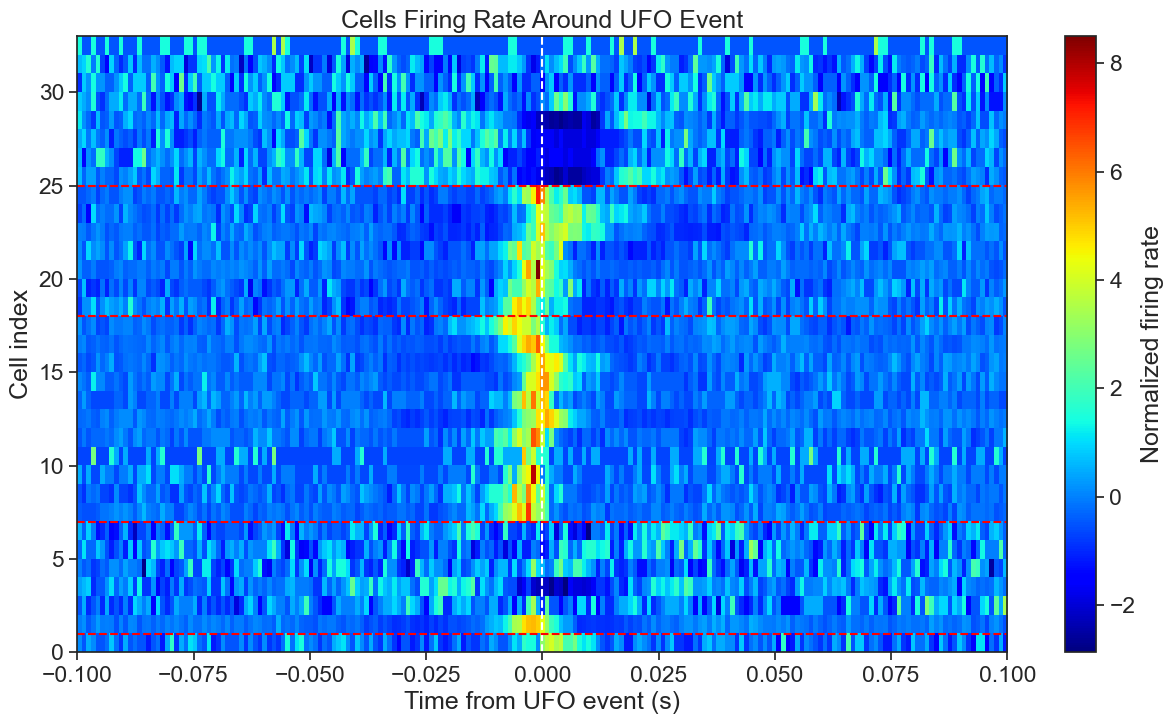

In [265]:
# Plotting with imshow
plt.figure(figsize=(15, 8))
plt.imshow(ccs_zscored.T, aspect='auto', cmap='jet', interpolation='none',extent=[-0.1, 0.1, 0, cc.shape[1]])
plt.colorbar(label='Normalized firing rate')
plt.axvline(0, color='white', linestyle='--') # This marks the time of the UFO event
# Add horizontal lines for group boundaries
for boundary in group_boundaries:
    plt.axhline(y=boundary, color='red', linestyle='--')
plt.title('Cells Firing Rate Around UFO Event')
plt.xlabel('Time from UFO event (s)')
plt.ylabel('Cell index')
plt.show()

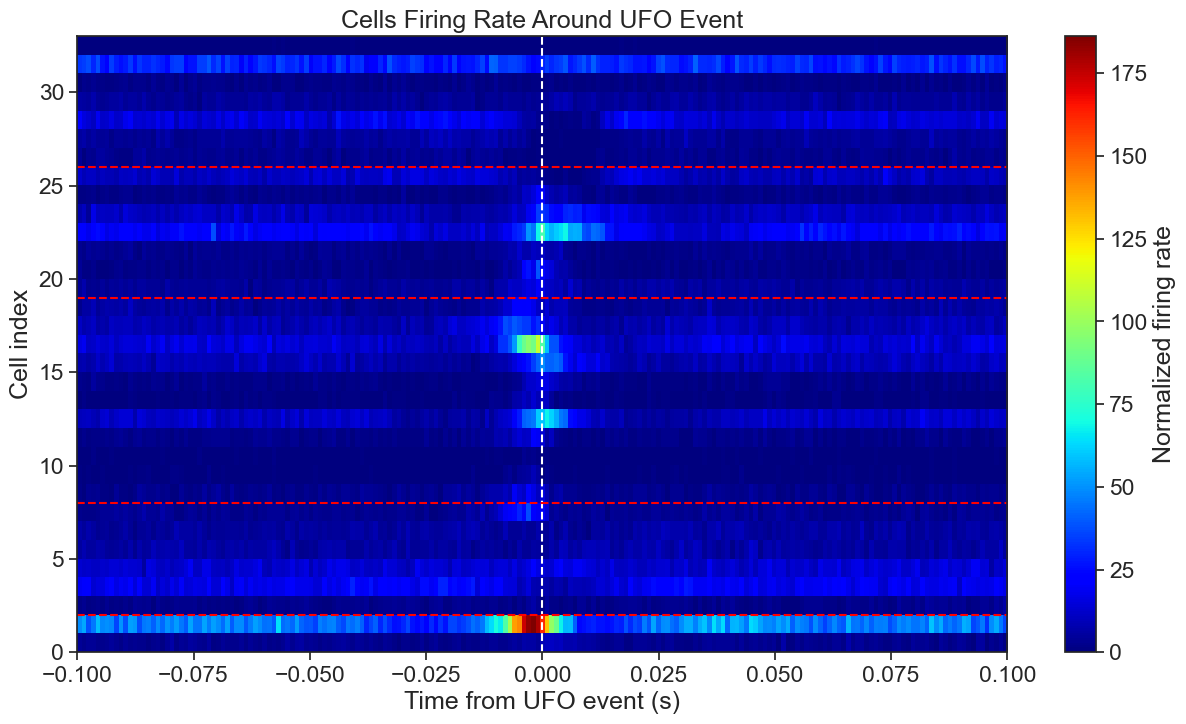

In [258]:

# Plotting with imshow
plt.figure(figsize=(15, 8))
plt.imshow(ccs.T, aspect='auto', cmap='jet', interpolation='none',extent=[-0.1, 0.1, 0, cc.shape[1]])
plt.colorbar(label='Normalized firing rate')
plt.axvline(0, color='white', linestyle='--') # This marks the time of the UFO event
# Add horizontal lines for group boundaries
for boundary in group_boundaries:
    plt.axhline(y=boundary, color='red', linestyle='--')
plt.title('Cells Firing Rate Around UFO Event')
plt.xlabel('Time from UFO event (s)')
plt.ylabel('Cell index')
plt.show()

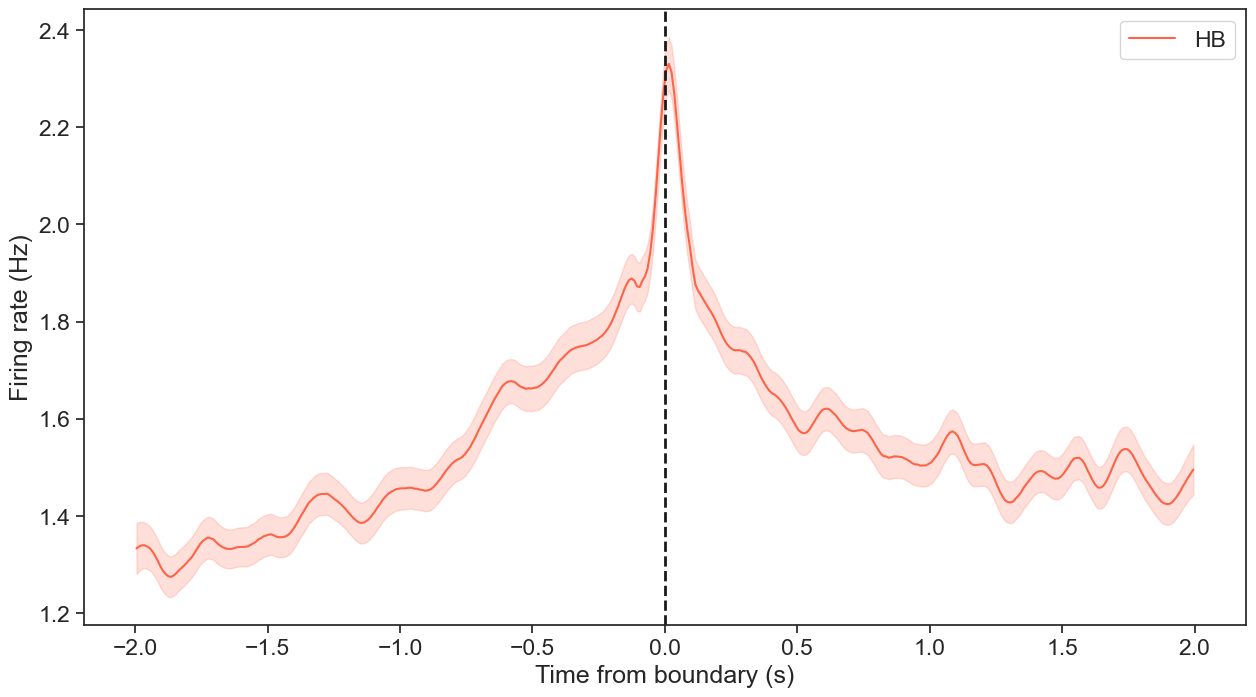

In [133]:
plt.figure(figsize =(15,8))
plt.plot(
    meanfr_ufo, color=[255 / 255, 99 / 255, 71 / 255], label="HB"
)  # Plot mean firing rate for HB trials

# Plot SEM for NB trials
plt.fill_between(
    meanfr_ufo.index.values,
    meanfr_ufo.values - error_ufo,
    meanfr_ufo.values + error_ufo,
    color=[255 / 255, 99 / 255, 71 / 255],
    alpha=0.2,
)

plt.axvline(0, linewidth=2, color="k", linestyle="--")  # Plot a line at t = 0
plt.xlabel("Time from boundary (s)")  # Time from boundary in seconds, on X-axis
plt.ylabel("Firing rate (Hz)")  # Firing rate in Hz on Y-axis
plt.legend(loc="upper right")

In [ ]:
lfp_sign

Time (s)       41    33    43    32    45  ...
-----------  ----  ----  ----  ----  ----  -----
3971.64195    538   644   748   610   739  ...
3971.642      406   516   696   770   734  ...
3971.64205    335   427   386   562   588  ...
3971.6421     265   262   183   423   382  ...
3971.64215    239   188   165   386   217  ...
...
12498.07755  -551  -805  -555  -608  -818  ...
12498.0776   -414  -706  -416  -545  -708  ...
12498.07765  -389  -419  -410  -386  -497  ...
12498.0777   -517  -475  -534  -365  -452  ...
12498.07775  -538  -527  -457  -514  -579  ...
dtype: int16, shape: (226322, 11)

In [57]:
freq_band = (500, 2000)
thres_band = (3, 100)
wsize = 2
duration_band = (2, 40)
min_inter_duration = 5

signal_sign = pyna.eeg_processing.bandpass_filter(lfp_sign2, freq_band[0], freq_band[1], fs)
power = np.abs(hilbert(signal_sign.d))
window = np.ones(wsize)/wsize
nSS = filtfilt(window, 1, power)
nSS = nSS - np.mean(nSS)
nSS_sign = nSS/np.std(nSS)     
meanSS = nSS_sign / len(sign_channels)

In [32]:
lfp_ctrl = data.load_lfp(channel=list(ctrl_channels),extension='.dat',frequency=fs)
lfp_ctrl=lfp_ctrl.restrict(ufo_ep)

In [34]:
signal_ctrl = pyna.eeg_processing.bandpass_filter(lfp_ctrl, freq_band[0], freq_band[1], fs)
power = np.abs(hilbert(signal_ctrl.d))
window = np.ones(wsize)/wsize
nSS = filtfilt(window, 1, power)
nSS = nSS - np.mean(nSS)
nSS_ctrl= nSS/np.std(nSS)     
meanctr = nSS_ctrl / len(ctrl_channels)

In [39]:
len(nSS_sign)

226322

In [63]:
ctrl_channels

array([ 5, 18,  7, 20,  9, 22, 11, 24,  3, 16,  1])

In [68]:
for j, c in enumerate(ctrl_channels):
    print(j,c)

0 5
1 18
2 7
3 20
4 9
5 22
6 11
7 24
8 3
9 16
10 1


In [58]:
nSS = meanSS - meanctr
nSS = nap.Tsd(t = lfp_sign2.t, d=nSS[:,0])
meanSS = nap.TsdFrame(t = lfp_sign2.t, d=meanSS)

#nSS2 = nSS.threshold(thres_band[0], method='above')
#nSS3 = nSS2.threshold(thres_band[1], method='below')

NameError: name 'lfp_sign' is not defined

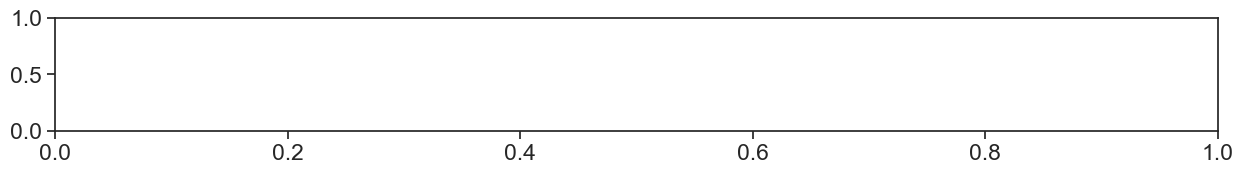

In [ ]:
figure(figsize=(15,5))
subplot(311)
plot(lfp_sign.restrict(ep).as_units('s'))
subplot(312)
plot(signal_sign.restrict(ep).as_units('s'))
subplot(313)
plot(nSS.restrict(ep).as_units('s'))
#plot(nSS3.restrict(exEp).as_units('s'), '.')
axhline(thres_band[0])
xlabel("Time (s)")
tight_layout()
show()

In [ ]:
bin_size = 0.2  # 200ms bin size
step_size = 0.01  # 10ms step size, to make overlapping bins
winsize = int(bin_size / step_size)  # Window size

In [8]:
nSS3_ufo=nap.load_file(data.path + '\\'+ data.basename+'_nSS3.npz')
nSS_ufo=nap.load_file(data.path + '\\'+ data.basename+'_nSS.npz')
signal_ufo=nap.load_file(data.path + '\\'+ data.basename+'_signal.npz')

In [22]:
ep=nap.IntervalSet(start=ufo_ep['start'][10],end=ufo_ep['end'][10])
ep

start         end
0  4039.79605  4039.80205

In [69]:
fp, timestep = get_memory_map(os.path.join(data.path, filename), data.nChannels)

In [80]:
fp[:,sign_channels]

KeyboardInterrupt: 

In [81]:
lfp=nap.TsdFrame(t=timestep,d=fp[:,sign_channels])

In [60]:
nSS.threshold(thres_band[0], method='above')

Time (s)
----------  --
dtype: float64, shape: (0,)

In [87]:
channels

{0: array([12,  6, 14,  4, 15,  2, 13,  0, 10,  8]),
 1: array([ 5, 18,  7, 20,  9, 22, 11, 24,  3, 16,  1]),
 2: array([31, 23, 30, 21, 28, 19, 26, 17, 29, 25, 27]),
 3: array([41, 33, 43, 32, 45, 34, 47, 36, 39, 35, 37]),
 4: array([44, 59, 42, 57, 40, 55, 38, 53, 46, 61, 63]),
 5: array([56, 50, 58, 48, 60, 49, 62, 51, 54, 52])}

In [96]:
s='DTN1'
datasets[s]

'\\A4002-200120b'

In [98]:
os.path.join(path, datasets[s].split("\\")[-1]+".clu."+str(ufo_channels_nb[s][0]))

'D:\\PeyracheLab Internship\\Data\\A4002-200120b\\A4002-200120b.clu.3'

In [88]:
channels[ufo_channels_nb['DTN1'][0]]

array([41, 33, 43, 32, 45, 34, 47, 36, 39, 35, 37])

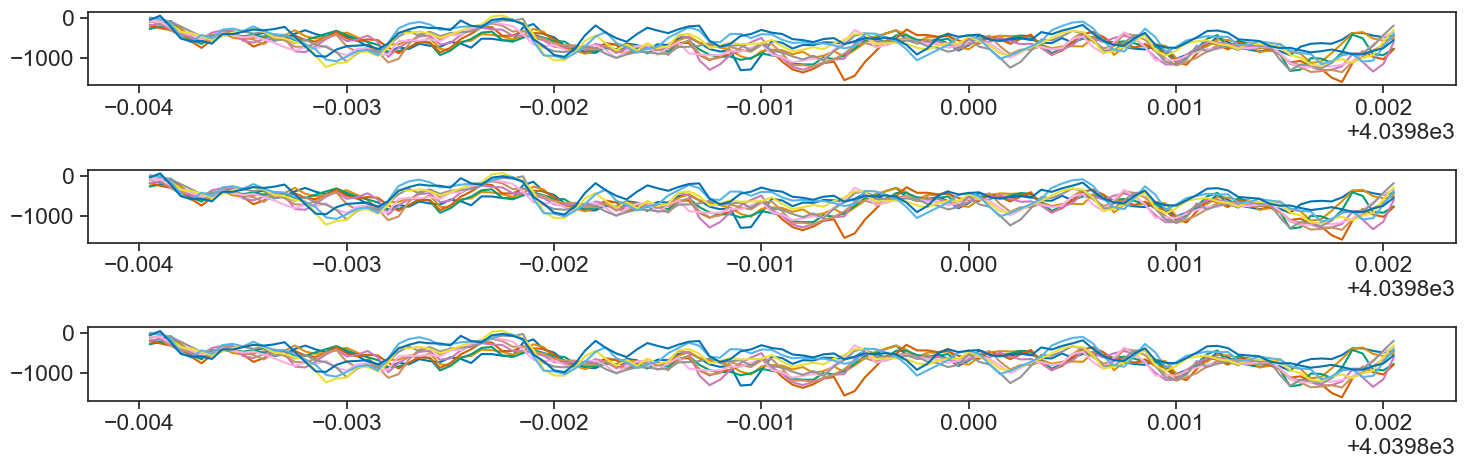

In [82]:
plt.figure(figsize=(15,5))
subplot(311)
plot(lfp_sign2.restrict(ep))
subplot(312)
plot(lfp.restrict(ep))
subplot(313)
plot(lfp_sign2.restrict(ep))
tight_layout()
show()

In [50]:
print(ufo_tsd.time_support)

       start        end
0  3971.6459  12498.076


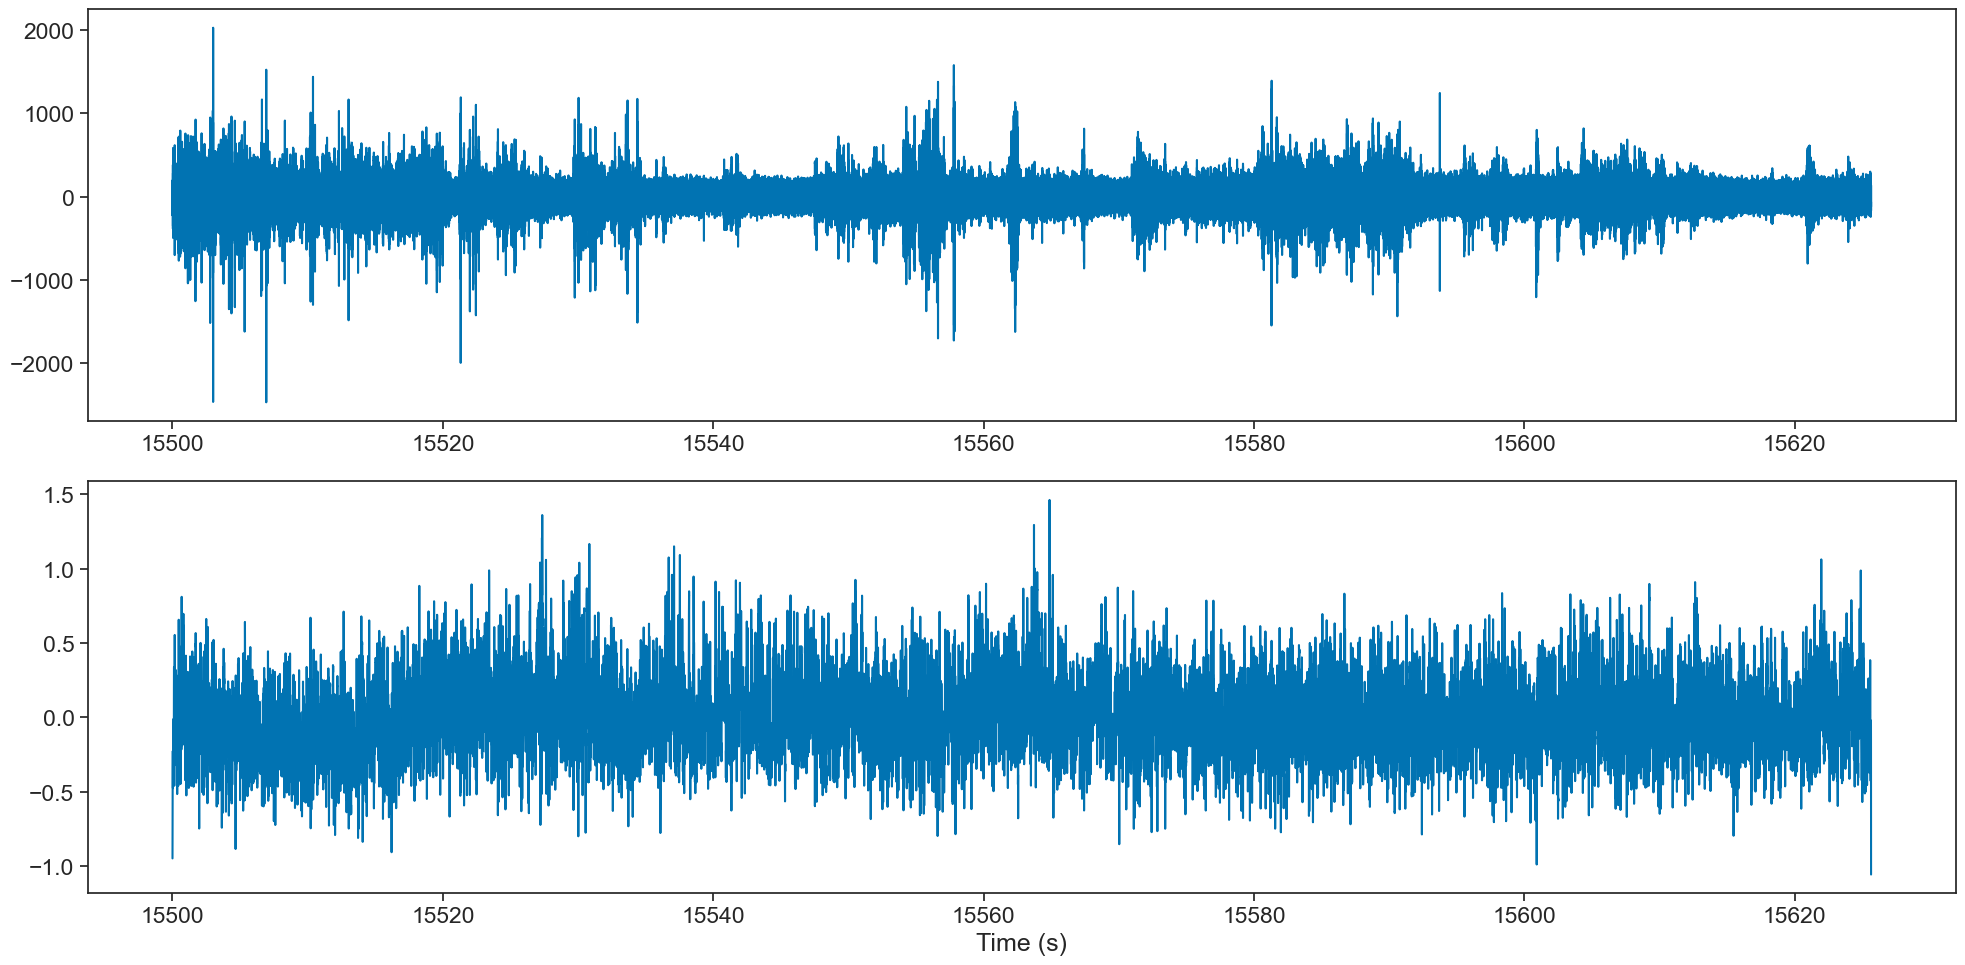

In [42]:
plt.figure(figsize=(20, 10))

# First subplot
plt.subplot(211)
plt.plot(signal_ufo)

# Second subplot
plt.subplot(212)
plt.plot(nSS_ufo)  # Corrected to use plt.plot

# Adding vertical lines for each value in ufo_tsd.index.values
#[plt.axvline(t, color='green') for t in ufo_tsd.index.values]

#plt.axhline(3)  # Horizontal line at y=3
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [6]:
tracking_data= pd.read_csv(path+r'\Analysis\Tracking_data.csv', header=None)
tracking_data.iloc[:, -3:] = (np.radians(tracking_data.iloc[:, -3:]) % (2 * np.pi))
position=nap.TsdFrame(t=tracking_data.iloc[:,0].values,d=tracking_data.iloc[:,-3:].values,time_support=nap.IntervalSet(start=min(tracking_data.iloc[:,0]), end=max(tracking_data.iloc[:,0])),columns=['ry','rz','rx'])
angle=position['ry']
angle

Time (s)
----------  -------
1.33        4.57042
1.34        5.70326
1.35        5.69073
1.36        5.67402
1.37        5.66396
...
15624.31    5.89269
15624.32    5.88844
15624.33    5.88486
15624.34    5.88403
15624.35    5.87846
dtype: float64, shape: (473625,)

In [7]:
angle=position['ry']

In [ ]:
position = data.position

angle=position['ry']

angle

In [8]:
data.load_neurosuite_xml(data.path)
channels = data.group_to_channel

epochs=data.epochs

wake_ep = data.epochs['wake']
sleep_ep = data.epochs['sleep']

spikes_sample = spikes.getby_category("location")[location]
#spikes_sample = spikes_sample.getby_category("group")[1]

ttl_epochs=nap.IntervalSet(start=position.time_support['start'][0], end=position.time_support['end'][0])

In [9]:
# Calculate the IQR
Q1 = np.percentile(angle, 25)
Q3 = np.percentile(angle, 75)
IQR = Q3 - Q1

# Calculate the number of data points
n = len(angle)

# Apply the Freedman-Diaconis rule to calculate bin width
bin_width = 2 * (IQR) / (n ** (1/3))

# Calculate the number of bins
range_of_data = np.max(angle.d) - np.min(angle.d)
num_bins = int(np.round(range_of_data / bin_width))

num_bins

78

In [10]:
tuning_curves = nap.compute_1d_tuning_curves(
    group=spikes_sample, 
    feature=angle, 
    nb_bins=num_bins, 
    ep = ttl_epochs,
    minmax=(0, 2 * np.pi)
    )

In [11]:
pref_ang = tuning_curves.idxmax()
norm = plt.Normalize()  # Normalizes data into the range [0,1]
color = plt.cm.hsv(norm([i / (2 * np.pi) for i in pref_ang.values]))  # Assigns a colour in the HSV colourmap for each value of preferred angle
color = pd.DataFrame(index=pref_ang.index, data = color, columns = ['r', 'g', 'b', 'a'])

smoothcurves = smoothAngularTuningCurvesHD(tuning_curves, sigma=3)

In [12]:
hd_labels={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 1, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0}

hd_group={}

for i in hd_labels.keys():
    if hd_labels[i]==1:
        hd_group[i]=spikes_sample.get_info('group')[i]

hd_group_list=np.unique(list(hd_group.values()))

hd_group_list

array([3, 4])

In [21]:
spikes_group1=spikes.getby_category("group")[3]
spikes_group2=spikes.getby_category("group")[4]

In [18]:
pd.Series(hd_labels)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    1
18    0
19    0
20    0
21    0
22    0
23    1
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
dtype: int64

In [19]:
spikes.set_info(HD=pd.Series(hd_labels))

In [101]:
print(ufo_ep)

            start          end
0      3971.64195   3971.64885
1      3971.78525   3971.78890
2      3991.46425   3991.47265
3      4010.46290   4010.46505
4      4015.61860   4015.62780
...           ...          ...
1633  12495.97740  12495.98370
1634  12496.53070  12496.53920
1635  12497.06055  12497.06760
1636  12497.66565  12497.67090
1637  12498.07390  12498.07775

[1638 rows x 2 columns]


In [ ]:
for i in hd_group_list:
    spikes_group=spikes.getby_category("group")[i]
nap.TsGroup(spikes, group=[3,4])

In [ ]:
def plot_ccs(ccs):
    for key, value in ccs.items():
        nb_epochs=len(value.keys())
    plt.figure(figsize=(15, 30))
    gs = GridSpec(len(ccs)+1, nb_epochs)
    for i, r in enumerate(ccs.keys()):
        for j, e in enumerate(ccs[r].keys()):
            ax = plt.subplot(gs[i, j])
            if i == 0:
                ax.set_title(e)
            if j == 0:
                ax.set_ylabel(r, rotation=0, labelpad=30)
            tmp = ccs[r][e].values
            tmp = (tmp - tmp.mean(0)) / tmp.std(0)
            tmp = tmp[:, np.where(~np.isnan(np.sum(tmp, 0)))[0]]
            im = ax.imshow(tmp.T, aspect='auto', cmap='jet')
            x = ccs[r][e].index.values
            ax.set_xticks([0, len(x)//2, len(x)], [x[0], 0.0, x[-1]])
            # Add colorbar to the last subplot in each row for clarity
            if j == len(ccs[r].keys()) - 1:
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Plotting means with legend
    for j, e in enumerate(ccs[r].keys()):
        ax = plt.subplot(gs[-1, j])
        for i, r in enumerate(ccs.keys()):
            ax.plot(ccs[r][e].mean(1), color=colors[i], linewidth=lw, label=r)
        ax.axvline(0.0, color='k')
        ax.set_xlim(x[0], x[-1])
        if j == 0:
            ax.legend()
plt.tight_layout()

In [ ]:
cc = nap.compute_crosscorrelogram(group=spikes,
                                  binsize=0.5,
                                  windowsize=100,
                                  ep=wake_ep,
                                  norm=True,
                                  time_units='s')

In [ ]:
cc

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(cc, alpha = 0.5, linewidth=1)
plt.plot(cc.mean(1), linewidth = 4, color = 'red', label = "SWR")
plt.title('Cross-Correlogram')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(25, 20))
for i, n in enumerate(pref_ang.sort_values().index.values):
    plt.subplot(8, 4, i + 1, projection='polar')  # Plot the curves in 8 rows and 4 columns
    #plt.plot(smoothcurves[n], color=color.loc[n])  # Colour of the curves determined by preferred angle
    plt.plot(tuning_curves[n])
    #plt.plot([pref_ang[n], pref_ang[n]], [0, max(max(smoothcurves[n]), max(tuning_curves[n]))], 'r--')  # 'r--' makes the line red and dashed
    plt.title(str(n))
    plt.xlabel("Angle (rad)")  # Angle in radian, on the X-axis
    plt.ylabel("Firing Rate (Hz)")  # Firing rate in Hz, on the Y-axis
    plt.xticks([])
plt.show()

In [ ]:
hd_labels = {}  # Initialize a dictionary to store HD cell labels

for i in tuning_curves.keys():
    # Calculate the variability of magnitudes in smoothcurves[i] to determine uniformity
    variability = np.std(smoothcurves[i]) / np.mean(smoothcurves[i]) if np.mean(smoothcurves[i]) > 0 else 0

    # Use a threshold to decide if the magnitudes are almost the same (low variability indicates no particular main direction)
    variability_threshold = 0.2  # This threshold is adjustable based on your dataset
    
    if variability < variability_threshold:
        #print(f"{i}: No particular main direction due to low variability in magnitudes.")
        hd_labels[i] = 0  # Label as non-HD cell
        continue 

    magnitudes = max(tuning_curves[i])
    
    # Main direction and magnitude of the resultant vector
    main_direction = pref_ang[i]
    main_magnitude = magnitudes
    
    # Define a minimum amplitude threshold
    min_amplitude = 5
    
    # Check for conditions
    if main_magnitude < 1e-5 or main_magnitude < min_amplitude:
        #print(f"{i}: Not an HD cell due to low magnitude.")
        hd_labels[i] = 0  # Label as non-HD cell
    else:
        #print(f"{i}: HD cell with main direction {np.degrees(main_direction)} degrees and magnitude {main_magnitude}.")
        hd_labels[i] = 1  # Label as HD cell

print(hd_labels)

In [ ]:
ufo_ep_file = os.path.join(data.path, data.basename + '_ufo_ep.npz')
ufo_tsd_file = os.path.join(data.path, data.basename + '_ufo_tsd.npz')
ufo_ep = nap.load_file(ufo_ep_file)
ufo_tsd = nap.load_file(ufo_tsd_file)

In [ ]:
# Writing for neuroscope
start = ufo_ep.as_units('ms')['start'].values
peaks = ufo_tsd.as_units('ms').index.values
ends = ufo_ep.as_units('ms')['end'].values

datatowrite = np.vstack((start,peaks,ends)).T.flatten()

n = len(ufo_ep)

texttowrite = np.vstack(((np.repeat(np.array(['UFO start 1']), n)),
                        (np.repeat(np.array(['UFO peak 1']), n)),
                        (np.repeat(np.array(['UFO stop 1']), n))
                            )).T.flatten()

evt_file = os.path.join(path, data.basename + '.evt.py.ufo')
f = open(evt_file, 'w')
for t, n in zip(datatowrite, texttowrite):
    f.writelines("{:1.6f}".format(t) + "\t" + n + "\n")
f.close()   

In [ ]:
ufo_ep, ufo_tsd = loadUFOsV2(path)
ufo_ep

## Head-Direction cells decoding

In [ ]:
decoded, proba_feature = nap.decode_1d(
    tuning_curves=tuning_curves,
    group=spikes_sample,
    ep=ttl_epochs,
    bin_size=0.1,  # second
    feature=angle)

In [ ]:
decoded

In [ ]:
ep = nap.IntervalSet(
    start=2480, end=2500
)  # Select an arbitrary interval for plotting

plt.figure()
plt.rc("font", size=12)
for i, n in enumerate(spikes_sample.keys()):
    plt.plot(
        spikes[n].restrict(ep).fillna(pref_ang[n]), "|", color=color.loc[n]
    )  # raster plot for each cell
plt.plot(
    decoded.restrict(ep), "--", color="grey", linewidth=2, label="decoded HD"
)  # decoded HD
plt.legend(loc="upper left")

In [ ]:
smoothed = scipy.ndimage.gaussian_filter(
    proba_feature, 1
)  # Smoothening the probability distribution

# Create a DataFrame with the smoothed distribution
p_feature = pd.DataFrame(
    index=proba_feature.index.values,
    columns=proba_feature.columns.values,
    data=smoothed,
)
p_feature = nap.TsdFrame(p_feature)  # Make it a Pynapple TsdFrame

plt.figure()
plt.plot(
    angle.restrict(ep), "w", linewidth=2, label="actual HD", zorder=1
)  # Actual HD, in white
plt.plot(
    decoded.restrict(ep), "--", color="grey", linewidth=2, label="decoded HD", zorder=1
)  # Decoded HD, in grey

# Plot the smoothed probability distribution
plt.imshow(
    np.transpose(p_feature.restrict(ep).values),
    aspect="auto",
    interpolation="bilinear",
    extent=[ep["start"][0], ep["end"][0], 0, 2 * np.pi],
    origin="lower",
    cmap="viridis",
)

plt.xlabel("Time (s)")  # X-axis is time in seconds
plt.ylabel("Angle (rad)")  # Y-axis is the angle in radian
plt.colorbar(label="probability")

## Sleep scoring

In [ ]:
############################################################################################### 
# Sleep State Detection Algorithm
###############################################################################################

# Required Libraries
from scipy.signal import butter, lfilter, welch

# Channel Configuration (example)
channel_configs = {
    'Session1': {'analysis_channels': [0, 2], 'bad_channels': [1]},
    'Session2': {'analysis_channels': [1, 3], 'bad_channels': [2]},
    # Define channel configurations for each session
}

# Define Sleep State Analysis Results Dictionary
sleep_states = {session: {'wake': [], 'sleep': []} for session in datasets.keys()}

# Signal Processing Functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def calculate_psd(signal, fs):
    freqs, psd = welch(signal, fs=fs, nperseg=1024)
    return freqs, psd

def detect_sleep_state(psd, freqs, low_freq_range=(0.5, 4), high_freq_range=(30, 50)):
    low_freq_power = np.sum(psd[(freqs >= low_freq_range[0]) & (freqs <= low_freq_range[1])])
    high_freq_power = np.sum(psd[(freqs >= high_freq_range[0]) & (freqs <= high_freq_range[1])])
    ratio = low_freq_power / (high_freq_power + 1e-6)  # Prevent division by zero
    state = 'Sleep' if ratio > 0.5 else 'Wake'
    return state

# Main Loop for Sleep State Analysis
for session, data_path in datasets.items():
    full_path = os.path.join(data_directory, data_path)
    analysis_channels = channel_configs[session]['analysis_channels']
    bad_channels = channel_configs[session]['bad_channels']

    # Load Your Data Here (adjust according to your data structure)
    # signal, fs = load_your_signal_data(full_path)

    for channel in analysis_channels:
        if channel in bad_channels:
            continue  # Skip bad channels
        
        # Filter Signal (adjust according to your needs)
        filtered_signal = butter_bandpass_filter(signal[channel], 0.5, 50, fs, order=4)
        
        # Calculate PSD
        freqs, psd = calculate_psd(filtered_signal, fs)
        
        # Detect Sleep State
        state = detect_sleep_state(psd, freqs)
        
        # Store Results
        sleep_states[session][state].append(channel)

# Example to Access and Use the Results
for session, states in sleep_states.items():
    print(f"Session: {session}")
    for state, channels in states.items():
        print(f"  State: {state}, Channels: {channels}")

## Cross-correlation

In [ ]:
# Define dictionaries to store long and short cross-correlograms
ccs_long = {r: {e: [] for e in ['wake', 'sleep']} for r in datasets.keys()}
ccs_short = {r: {e: [] for e in ['wake', 'sleep']} for r in datasets.keys()}

# Define spike index (SI) thresholds
SI_thr = {'LMN':0,
    'MMN':0,
    'PostSUB':0,
    'DTN1': 0,
    'DTN2': 0,
    'DTN3': 0,
    'DTN4': 0,
    'DTN5': 0}

# Loop through each session in datasets
for s in datasets.keys():
    # Load session data
    path = data_directory + datasets[s]
    data = ntm.load_session(path, 'neurosuite')
    spikes = data.spikes
    position = data.position
    wake_ep = data.epochs['wake']
    sleep_ep = data.epochs['sleep']
    #ufo_ep, ufo_tsd = loadUFOs(path)

    # Check for existing UFO epoch and tsd files, load if present
    ufo_ep_file = os.path.join(data.path, data.basename + '_ufo_ep.npz')
    ufo_tsd_file = os.path.join(data.path, data.basename + '_ufo_tsd.npz')
    if os.path.exists(ufo_ep_file) and os.path.exists(ufo_tsd_file):
        ufo_ep = nap.load_file(ufo_ep_file)
        ufo_tsd = nap.load_file(ufo_tsd_file)
    else:
        # Compute and save UFO detection results if files don't exist
        tuning_curves = nap.compute_1d_tuning_curves(spikes, position['ry'], 120, minmax=(0, 2*np.pi), ep=position.time_support.loc[[0]])
        data.load_neurosuite_xml(data.path)
        channels = data.group_to_channel
        sign_channels = channels[ufo_channels_nb[s][0]]
        ctrl_channels = channels[ufo_channels_nb[s][1]]
        filename = data.basename + ".dat"    
        fp, timestep = get_memory_map(os.path.join(data.path, filename), data.nChannels)
        ufo_ep, ufo_tsd = detect_ufos_v2(fp, sign_channels, ctrl_channels, timestep)
        ufo_ep.save(os.path.join(path, data.basename + '_ufo_ep'))
        ufo_tsd.save(os.path.join(path, data.basename + '_ufo_tsd'))

    location=''.join([char for char in s if char.isalpha()])

    # Filter spikes based on metadata
    idx = spikes._metadata[spikes._metadata["location"].str.contains(location)].index.values
    spikes = spikes[idx]

    # If UFO TSD is not None, proceed with computing tuning curves and cross-correlograms
    if ufo_tsd is not None:
        tuning_curves = nap.compute_1d_tuning_curves(spikes, position['ry'], 120, minmax=(0, 2*np.pi), ep=position.time_support.loc[[0]])
        tuning_curves = smoothAngularTuningCurves(tuning_curves, 20, 4)
        SI = nap.compute_1d_mutual_info(tuning_curves, position['ry'], position['ry'].time_support.loc[[0]], minmax=(0,2*np.pi))
        spikes = spikes[SI[SI['SI']>SI_thr[s]].index.values]
        names = [s.split("/")[-1] + "_" + str(n) for n in spikes.keys()]

        for e, ep in zip(['wake', 'sleep'], [wake_ep, sleep_ep]):            
            cc = nap.compute_eventcorrelogram(spikes, ufo_tsd, 0.01, 0.6, ep, norm=True)
            cc.columns = names
            ccs_long[s][e].append(cc)

            cc = nap.compute_eventcorrelogram(spikes, ufo_tsd, 0.0005, 0.015, ep, norm=True)
            cc.columns = names
            ccs_short[s][e].append(cc)
    else:
        print("No UFO in " + s)

# Concatenate cross-correlograms across sessions for each condition and epoch
for r in ccs_long.keys():
    for e in ccs_long[r].keys():
        ccs_long[r][e] = pd.concat(ccs_long[r][e], axis=1)
        ccs_short[r][e] = pd.concat(ccs_short[r][e], axis=1)

# Set plot parameters and initialize color cycle
plt.rcParams.update({'font.size': 15})
lw = 2
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Function to plot cross-correlograms
def plot_ccs(ccs):
    plt.rcParams.update({'font.size': 15})
    lw = 2
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for key, value in ccs.items():
        nb_epochs=len(value.keys())
    plt.figure(figsize=(15, 30))
    gs = GridSpec(len(ccs)+1, nb_epochs)
    for i, r in enumerate(ccs.keys()):
        for j, e in enumerate(ccs[r].keys()):
            ax = plt.subplot(gs[i, j])
            if i == 0:
                ax.set_title(e)
            if j == 0:
                ax.set_ylabel(r, rotation=0, labelpad=30)
            tmp = ccs[r][e].values
            tmp = (tmp - tmp.mean(0)) / tmp.std(0)
            tmp = tmp[:, np.where(~np.isnan(np.sum(tmp, 0)))[0]]
            im = ax.imshow(tmp.T, aspect='auto', cmap='jet')
            x = ccs[r][e].index.values
            ax.set_xticks([0, len(x)//2, len(x)], [x[0], 0.0, x[-1]])
            # Add colorbar to the last subplot in each row for clarity
            if j == len(ccs[r].keys()) - 1:
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Plotting means with legend
    for j, e in enumerate(ccs[r].keys()):
        ax = plt.subplot(gs[-1, j])
        for i, r in enumerate(ccs.keys()):
            ax.plot(ccs[r][e].mean(1), color=colors[i], linewidth=lw, label=r)
        ax.axvline(0.0, color='k')
        ax.set_xlim(x[0], x[-1])
        if j == 0:
            ax.legend()
    plt.tight_layout()

# Call plotting functions
plot_ccs(ccs_long)
plot_ccs(ccs_short)


In [ ]:
ufo_ep

## Spectrogram

In [ ]:
datasets = {'LMN':r'\A3024-220915A', 
            'DTN2':r'\A4014-210616'}

ufo_channels_nb = {'LMN':[1,0], 
            'DTN2':[1,3]}

In [ ]:
datasets = {'LMN':r'\A3024-220915A'}

ufo_channels_nb = {'LMN':[1,0]}

In [ ]:
# Calculate the total number of datasets for subplot dimensions
n_datasets = len(datasets)
    
# Create a figure with subplots for each dataset
fig, axs = plt.subplots(n_datasets, 1, figsize=(15, 5 * n_datasets))

for i, s in enumerate(datasets.keys()):    
    path = data_directory + datasets[s]
    data = ntm.load_session(path, 'neurosuite')
    spikes = data.spikes
    position = data.position

    data.load_neurosuite_xml(data.path)

    filename = data.basename + ".dat"    
    fp, timestep = get_memory_map(os.path.join(data.path, filename), data.nChannels)
    print("Step 1 DONE!")

    #channels = data.group_to_channel[np.unique(spikes._metadata["group"].values)[0]]    
    channels = data.group_to_channel
    sign_channels=channels[ufo_channels_nb[s][0]][2]

    lfp = nap.Tsd(t=timestep, d=fp[:,sign_channels])
    print("Step 2 DONE!")


    sample_ep = nap.IntervalSet(start = 1000, end = 1200)
    lfp=lfp.restrict(sample_ep)
    print("Step 3 DONE!")

    tmp=lfp.t
    sig=lfp.d
    t = np.arange(0, len(s))*(1/fs)
    sig_windowed = sig * np.blackman(len(lfp.d))  # Apply windowing

    power, times, freqs = stft_gaussian_spectrogram(sig_windowed, fs)
    coif = np.zeros(times.shape)

            
    print(f"Processing {s}...")
     # Generate spectrogram for the current subplot
    ax = spectrogram_plot(power, times, freqs, coif, cmap='jet', norm=LogNorm(), ax=axs[i])
    axs[i].set_ylabel(f"{s}\nFrequency (Hz)")
    axs[i].set_ylim(0, 100)
    axs[i].grid(False)
    print("Step 4 DONE!")


for ax in axs:
    ax.set_xlabel("Time (s)")   
    
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the total number of datasets for subplot dimensions
n_datasets = len(datasets)
    
# Create a figure with subplots for each dataset
fig, axs = plt.subplots(n_datasets, 1, figsize=(15, 5 * n_datasets))

for i, s in enumerate(datasets.keys()):    
    path = data_directory + datasets[s]
    data = ntm.load_session(path, 'neurosuite')
    spikes = data.spikes
    position = data.position

    data.load_neurosuite_xml(data.path)

    filename = data.basename + ".dat"    
    fp, timestep = get_memory_map(os.path.join(data.path, filename), data.nChannels)
    print("Step 1 DONE!")

    #channels = data.group_to_channel[np.unique(spikes._metadata["group"].values)[0]]    
    channels = data.group_to_channel
    sign_channels=channels[ufo_channels_nb[s][0]][2]

    lfp = nap.Tsd(t=timestep, d=fp[:,sign_channels])
    print("Step 2 DONE!")


    sample_ep = nap.IntervalSet(start = 1000, end = 3000)
    lfp=lfp.restrict(sample_ep)
    print("Step 3 DONE!")

    tmp=lfp.t
    signal=lfp.d
    t = np.arange(0, len(s))*(1/fs)
    signal_windowed = signal * np.blackman(len(lfp.d))  # Apply windowing
            
    print(f"Processing {s}...")
     # Generate spectrogram for the current subplot
    *_, im = axs[i].specgram(signal_windowed, Fs=fs, NFFT=256, noverlap=200,cmap='jet', mode='magnitude', norm=LogNorm())
    axs[i].set_ylabel(f"{s}\nFrequency (Hz)")
    axs[i].set_ylim(0, 100)
    axs[i].grid(False)

    # Add colorbar for each subplot
    cbar = plt.colorbar(im, ax=axs[i], pad=0.01)
    cbar.set_label('Intensity (dB)', rotation=270, labelpad=15)
    print("Step 4 DONE!")


for ax in axs:
    ax.set_xlabel("Time (s)")   
    
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the total number of datasets for subplot dimensions
n_datasets = len(datasets)
    
# Create a figure with subplots for each dataset
fig, axs = plt.subplots(n_datasets, 1, figsize=(15, 5 * n_datasets))

for i, s in enumerate(datasets.keys()):    
    ############################################################################################### 
    # LOADING DATA
    ###############################################################################################
    path = data_directory + datasets[s]
    data = ntm.load_session(path, 'neurosuite')
    spikes = data.spikes
    position = data.position
    wake_ep = data.epochs['wake']
    sleep_ep = data.epochs['sleep']
    try:
        ufo_ep_file = os.path.join(data.path, data.basename + '_ufo_ep.npz')
        ufo_ep = nap.load_file(ufo_ep_file)
    except:
        pass
    # ufo_ep, ufo_ts = loadUFOs(path)

    location=''.join([char for char in s if char.isalpha()])

    # Filter spikes based on metadata
    idx = spikes._metadata[spikes._metadata["location"].str.contains(location)].index.values
    spikes = spikes[idx]

    data.load_neurosuite_xml(data.path)
    #channels = data.group_to_channel[np.unique(spikes._metadata["group"].values)[0]]    
    channels = data.group_to_channel
    sign_channels=channels[ufo_channels_nb[s][0]]
    filename = data.basename + ".dat"    
            
    fp, timestep = get_memory_map(os.path.join(data.path, filename), data.nChannels)

    timestep = nap.Tsd(t=timestep, d=np.arange(len(timestep)))

    sample_ep = nap.IntervalSet(start = 1000, end = 5000)

    #tmp = timestep.restrict(sample_ep)
    tmp=timestep
    lfp = fp[tmp.values[0]:tmp.values[-1]]
    lfp = lfp[:,channels]


    s = lfp[:,0]
    t = np.arange(0, len(s))*(1/20000)
    s_windowed = s * np.blackman(len(s))  # Apply windowing
            
    print(f"Processing {s}...")
     # Generate spectrogram for the current subplot
    axs[i].specgram(s_windowed, Fs=20000, NFFT=256, noverlap=200, cmap='jet', mode='magnitude')
    axs[i].set_ylabel(f"{s}\nFrequency (Hz)")
    axs[i].set_ylim(0, 2000)  # Adjust the frequency range as needed
    axs[i].grid(False)

for ax in axs:
    ax.set_xlabel("Time (s)")   
    
plt.tight_layout()
plt.show()


In [ ]:
mean_spect = {g:{} for g in datasets.keys()}

for s, dataset in datasets.items():

    path = data_directory + dataset
    data = ntm.load_session(path, 'neurosuite')
    spikes = data.spikes
    position = data.position
    wake_ep = data.epochs['wake']
    sleep_ep = data.epochs['sleep']

    try:
        ufo_ep_file = os.path.join(data.path, data.basename + '_ufo_ep.npz')
        ufo_tsd_file = os.path.join(data.path, data.basename + '_ufo_tsd.npz')
        ufo_ep = nap.load_file(ufo_ep_file)
        ufo_tsd = nap.load_file(ufo_tsd_file)
    except FileNotFoundError:
        print(f"UFO files not found for session {s}")

    if ufo_tsd is not None:
        data.load_neurosuite_xml(data.path)
        channels = data.group_to_channel
        print('Step 1 DONE!')
        
        #if s == "LMN":
        sign_channels = channels[ufo_channels_nb[s][0]]
        print('Step 2 DONE!')
        #else:
        #    location=''.join([char for char in s if char.isalpha()])
        #    sign_channels = channels[np.unique(spikes.getby_category("location")[location].get_info("group"))[0]]

        filename = os.path.join(data.path, data.basename + ".dat")
        fp, timestep = get_memory_map(filename, data.nChannels)
        print('Step 3 DONE!')

        fs = 20000.0
        dt = 1/fs
        w = 5.
        freq = np.geomspace(100, 2000, 200)
        widths = w * fs / (2 * freq * np.pi)
        windowsize = 0.05
        N = int(windowsize / dt) * 2
        pwr = np.zeros((len(freq), N))
        count = 0.0

        st = np.searchsorted(timestep, ufo_tsd.t)
        st = st[(st > N // 2) & (st < len(timestep) - N // 2 - 1)]
        print('Step 4 DONE!')

        def compute_normalized_cwt(args):
            c, lfp, freq, N, widths, w = args
            cwtm = signal.cwt(lfp, signal.morlet2, widths, w=w)
            tmp = np.abs(cwtm)
            tmp /= tmp.sum(1)[:, np.newaxis]
            return tmp

        with Pool(len(sign_channels)) as p:
            for i, t in enumerate(st):
                items = [(c, fp[t-N//2:t+N//2, c], freq, N, widths, w) for c in sign_channels]
                print('okayyy')
                tmp = np.sum(p.map(compute_normalized_cwt, items), 0)
                print('hi')
                pwr += tmp
                count += len(sign_channels)
                print()
        print('Step 5 DONE!')

        pwr /= count
        mean_spect[s] = pwr
        print('Step 6 DONE!')

t = np.arange(0, N) * dt - (N // 2) * dt

spect = {g:np.array([mean_spect[g][s] for s in mean_spect[g].keys()]).mean(0) for g in mean_spect}

figure(figsize=(20,10))
gs = GridSpec(2,3)
for i, g in enumerate(spect.keys()):
    plt.subplot(gs[0,i])
    plt.imshow(spect[g], aspect='auto', origin='lower')
    plt.title(g)
    # yticks(np.arange(0, len(logfreq), 3), logfreq.astype("int")[::3])
    plt.yticks(np.arange(0, len(freq), 20), freq.astype("int")[::20])
    plt.xticks(np.arange(0, N, 200), (t[np.arange(0, N, 200)]*1000).astype("int"))
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency")

    plt.subplot(gs[1,i])
    plt.semilogx(freq, spect[g][:,1000])        
    plt.xlabel("Frequency")

plt.tight_layout()

In [ ]:
mean_spect = {g:{} for g in datasets.keys()}


for s in datasets.keys():

    # Load session data
    path = data_directory + datasets[s]
    data = ntm.load_session(path, 'neurosuite')
    spikes = data.spikes
    position = data.position
    wake_ep = data.epochs['wake']
    sleep_ep = data.epochs['sleep']
    #ufo_ep, ufo_tsd = loadUFOs(path)

    try:
        ufo_ep_file = os.path.join(data.path, data.basename + '_ufo_ep.npz')
        ufo_ep = nap.load_file(ufo_ep_file)
        ufo_tsd_file = os.path.join(data.path, data.basename + '_ufo_tsd.npz')
        ufo_tsd = nap.load_file(ufo_tsd_file)
    except:
        pass

    if ufo_tsd is not None:        

        # Memory map
        data.load_neurosuite_xml(data.path)
        channels = data.group_to_channel

        if s == "LMN":
            sign_channels = channels[ufo_channels_nb[s][0]]
        else:
            location=''.join([char for char in s if char.isalpha()])
            sign_channels = channels[np.unique(spikes.getby_category("location")[location].get_info("group"))[0]]

        filename = data.basename + ".dat"
                
        fp, timestep = get_memory_map(os.path.join(data.path, filename), data.nChannels)            

        fs = 20000.0
        dt = 1/fs
        w = 5.
        # freq = np.linspace(100, 2000, 100)
        freq = np.geomspace(100, 2000, 200)
        widths = w*fs / (2*freq*np.pi)
        windowsize = 0.05
        N = int(windowsize/dt)*2          
        pwr = np.zeros((len(freq),N))
        count = 0.0

        #############################
        st = np.searchsorted(timestep, ufo_tsd.t)
        st = st[st>N//2]
        st = st[st<len(timestep)-N//2-1]

        def func(args):                
            channel, lfp, freq, N, sign_channels, windowsize, dt, widths, w = args
            pwr2 = np.zeros((len(freq),N))
            count2 = 0.0
            cwtm = signal.cwt(lfp, signal.morlet2, widths, w=w)
            tmp = np.abs(cwtm)
            tmp /= tmp.sum(1)[:,np.newaxis]
            return tmp

        n_core = len(sign_channels)            
        p = Pool(n_core)

        for i, t in enumerate(st):
        
            print(s, 100*i/len(ufo_tsd))

            items = []
            lfp = fp[t-N//2:t+N//2,:]
            for j, c in enumerate(sign_channels):                    
                items.append((c, np.array(lfp[:,c]), freq, N, sign_channels, windowsize, dt, widths, w))

            tmp = p.map_async(func, items).get()

            pwr += np.sum(np.array(tmp), 0)
            count += len(sign_channels)
            # sys.exit()
            # for j, c in enumerate(sign_channels):
            
            #     cwtm = signal.cwt(fp[st-int(windowsize/dt):st+int(windowsize/dt),c], signal.morlet2, widths, w=w)
            #     tmp = np.abs(cwtm)
            #     tmp /= tmp.sum(1)[:,np.newaxis]
            #     pwr += tmp
            #     count += 1.0
            
        pwr = pwr/count

        mean_spect[s] = pwr

t = np.arange(0, N)*dt - (N//2)*dt

spect = {g:np.array([mean_spect[g][s] for s in mean_spect[g].keys()]).mean(0) for g in mean_spect}


figure(figsize=(20,10))
gs = GridSpec(2,3)
for i, g in enumerate(spect.keys()):
    plt.subplot(gs[0,i])
    plt.imshow(spect[g], aspect='auto', origin='lower')
    plt.title(g)
    # yticks(np.arange(0, len(logfreq), 3), logfreq.astype("int")[::3])
    plt.yticks(np.arange(0, len(freq), 20), freq.astype("int")[::20])
    plt.xticks(np.arange(0, N, 200), (t[np.arange(0, N, 200)]*1000).astype("int"))
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency")

    plt.subplot(gs[1,i])
    plt.semilogx(freq, spect[g][:,1000])        
    plt.xlabel("Frequency")

plt.tight_layout()

## UFO Up states

In [ ]:
ccs = {r:{e:[] for e in ['up', 'down']} for r in datasets.keys()}

for s, dataset in datasets.items():

    path = data_directory + dataset
    data = ntm.load_session(path, 'neurosuite')
    spikes = data.spikes
    position = data.position
    wake_ep = data.epochs['wake']
    sleep_ep = data.epochs['sleep']


    try:
        up_ep = data.read_neuroscope_intervals('up')
        up_ts = up_ep.starts
        down_ep = data.read_neuroscope_intervals('down')
        down_ts = down_ep.get_intervals_center()
    except:
        print("No up in "+s)
        up_ts = None

    if ufo_ts is not None and up_ts is not None:
        for e, ts in zip(['up', 'down'], [up_ts, down_ts]):
            grp = nap.TsGroup({0:ts,1:ufo_ts}, evt = np.array([e, 'ufo']))

            cc = nap.compute_crosscorrelogram(grp, 0.01, 1, sws_ep)
            cc.columns = [s.split("/")[-1]]

            ccs[r][e].append(cc)


for r in ccs.keys():
    for e in ccs[r].keys():
        ccs[r][e] = pd.concat(ccs[r][e], 1)


rcParams.update({'font.size': 15})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lw = 2

figure(figsize = (8, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

gs = GridSpec(3,2)
for i, r in enumerate(['adn', 'psb']):
    for j, e in enumerate(ccs[r].keys()):
        subplot(gs[i,j])
        if i == 0:
            title(e)
        if j == 0:
            ylabel(r, rotation=0, labelpad = 30)
        tmp = ccs[r][e].values
        tmp = tmp - tmp.mean(0)
        tmp = tmp / tmp.std(0)
        imshow(tmp.T, aspect='auto', cmap = 'jet')
        x = ccs[r][e].index.values
        xticks([0, len(x)//2, len(x)], [x[0], 0.0, x[-1]])

for j, e in enumerate(ccs[r].keys()):
    subplot(gs[-1,j])
    for i, r in enumerate(['adn', 'psb']):
        plot(ccs[r][e].mean(1), color = colors[i+1], linewidth=lw, label = r)
    axvline(0.0)
    xlim(x[0], x[-1])
    legend(frameon=False)
    xlabel("CC "+e+"/ufo")
tight_layout()
savefig(os.path.expanduser("~/Dropbox/UFOPhysio/figures/ALL_CC_UFO_UPDOWN.png"))


figure(figsize = (6, 12))
tmp = ccs['adn']['up']
animals = np.array([i.split("-")[0] for i in tmp.columns])

for i, a in enumerate(np.unique(animals)):
    subplot(len(np.unique(animals)), 1, i+1)
    plot(tmp[tmp.columns[animals==a]])   
    xlabel("CC "+e+"/ufo")
tight_layout()
